# Testing regularization term effect

This notebook implements a test for examining the addition of regularization term effect on training. See below run commands examples:

In [ ]:
Not_for_run;
# 1. Run 'Loading Env' and 'Test class' sections code

# 2. Creating a test instance:
description = 'Some description for the test'
test = TestRegularizationTermEffect(new_test = True, nof_epochs = 12500, verbose = True, seed = 621,\
                                    test_description = description)

# 3. Running training procedure:
test.train_and_record()

# 4. Plotting training process:
test.plot(start = 0, end = 3500, save = True)
test.plot(save = True)

# 5. Reconstruction procedure:
# 5.1 Run 'Reconstruction' section code.
# 5.2 When the test instance was created, it created several folders under a run-dir.
#     This run-dir is located under 'results' folder and looks like this 'MM_DD_HH_mm_ss_NNNNNN_test_data_norm'
# 5.3 Then run:
loaded_test_folder    = 'MM_DD_HH_mm_ss_NNNNNN_test_data_norm'
reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 621)

# 6. Visualozation
# 6.1 Run 'Visualization' section code.
# 6.2 Then run:
loaded_test_folder    = 'MM_DD_HH_mm_ss_NNNNNN_test_data_norm'
plot_reco(loaded_test_folder, save = True)

# Loading Env

In [ ]:
# connecting to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading env, ~3Min
colab = True

run_dir = '/content/drive/My Drive/ColabFiles/CifarReconstruct/'

import datetime
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import sys
import torch
import torchvision
import numpy as np

if colab == False:
  import caffeine

%cd /content/drive/My Drive/ColabFiles/CifarReconstruct/
# files containing training code
from GetParams import get_args
#from common_utils.common import save_weights
from common_utils.common import now
from common_utils.common import dump_obj_with_dict
from common_utils.common import load_dict_to_obj
from common_utils.common import load_weights

%cd /content/drive/My Drive/ColabFiles/CifarReconstruct/packages/kornia/
#print("no import kornia.metrics as metrics")
import kornia.metrics as metrics
%cd /content/drive/My Drive/ColabFiles/CifarReconstruct/
from common_utils.image import get_ssim_all, get_ssim_pairs_kornia

from extraction import get_trainable_params
from extraction import calc_extraction_loss, evaluate_extraction



from CreateModel import create_model

from Main import data_extraction

print(torchvision.__version__)
print(torch.__version__)
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

/content/drive/My Drive/ColabFiles/CifarReconstruct
/content/drive/My Drive/ColabFiles/CifarReconstruct/packages/kornia
/content/drive/My Drive/ColabFiles/CifarReconstruct
0.18.1+cu121
2.3.1+cu121
MPS not available because the current PyTorch install was not built with MPS enabled.


In [ ]:
import torch
import torchvision.datasets
import torchvision.transforms
import math


def load_bound_dataset(dataset, batch_size, shuffle=False, start=None, end=None, **kwargs):
    def _bound_dataset(dataset, start, end):
        if start is None:
            start = 0
        if end is None:
            end = len(dataset)
        return torch.utils.data.Subset(dataset, range(start, end))

    dataset = _bound_dataset(dataset, start, end)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=shuffle, **kwargs)


def fetch_cifar10(root, train=False, transform=None, target_transform=None):
    transform = transform if transform is not None else torchvision.transforms.ToTensor()
    dataset = torchvision.datasets.CIFAR10(root, train=train, transform=transform, target_transform=target_transform, download=True)
    return dataset


def load_cifar10(root, batch_size, train=False, transform=None, target_transform=None, **kwargs):
    dataset = fetch_cifar10(root, train, transform, target_transform)
    return load_bound_dataset(dataset, batch_size, **kwargs)


def move_to_type_device(x, y, device, verbose = False):
    if verbose: print(f'setting dtype as {torch.get_default_dtype()} from default')
    x = x.to(torch.get_default_dtype())
    y = y.to(torch.get_default_dtype())
    x, y = x.to(device), y.to(device)
    return x, y


def create_labels(y0):
    # airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, trucks
    # 4 subclasses of machines; 6 subclasses of animals
    labels_dict = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0}
    y0 = torch.stack([torch.tensor(labels_dict[int(cur_y)]) for cur_y in y0])
    return y0


def get_balanced_data(args, data_loader, data_amount, verbose = True):
    if verbose: print('BALANCING DATASET...')
    # get balanced data
    data_amount_per_class = data_amount // 2

    labels_counter = {1: 0, 0: 0}
    sublabels_cnt = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, \
                     5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    nof_vehicl = 4
    nof_animal = 6
    data_amount_per_sub_class_vehicl = math.floor(data_amount / (nof_vehicl * 2))
    data_amount_per_sub_class_animal = math.floor(data_amount / (nof_animal * 2))

    x0, y0 = [], []
    got_enough = False
    for bx, by in data_loader:
        # verify sublabels before mapping to label
        by_multy = create_labels(by)
        for i in range(len(bx)):
            if labels_counter[int(by_multy[i])] < data_amount_per_class and\
                ((int(by_multy[i]) == 0 and sublabels_cnt[int(by[i])] < data_amount_per_sub_class_vehicl) or\
                 (int(by_multy[i]) == 1 and sublabels_cnt[int(by[i])] < data_amount_per_sub_class_animal) or\
                 (int(by_multy[i]) == 0 and\
                  sublabels_cnt[int(0)] >= data_amount_per_sub_class_vehicl and\
                  sublabels_cnt[int(1)] >= data_amount_per_sub_class_vehicl and\
                  sublabels_cnt[int(8)] >= data_amount_per_sub_class_vehicl and\
                  sublabels_cnt[int(9)] >= data_amount_per_sub_class_vehicl and\
                  sublabels_cnt[int(by[i])] <= data_amount_per_sub_class_vehicl) or\
                 (int(by_multy[i]) == 1 and\
                  sublabels_cnt[int(2)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(3)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(4)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(5)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(6)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(7)] >= data_amount_per_sub_class_animal and\
                  sublabels_cnt[int(by[i])] <= data_amount_per_sub_class_animal)):

                labels_counter[int(by_multy[i])] += 1
                sublabels_cnt[int(by[i])] += 1
                x0.append(bx[i])
                y0.append(by_multy[i])
            if (labels_counter[0] >= data_amount_per_class) and (labels_counter[1] >= data_amount_per_class):
                got_enough = True
                break
        if got_enough:
            break

    # verify balancness
    balanced = True
    vehicl_cnts = [sublabels_cnt[0],\
                   sublabels_cnt[1],\
                   sublabels_cnt[8],\
                   sublabels_cnt[9],\
                   ]
    animal_cnts = [sublabels_cnt[2],\
                   sublabels_cnt[3],\
                   sublabels_cnt[4],\
                   sublabels_cnt[5],\
                   sublabels_cnt[6],\
                   sublabels_cnt[7],\
                   ]
    labels_dict = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0}
    if max(vehicl_cnts) - min(vehicl_cnts) > 1 or\
       max(animal_cnts) - min(animal_cnts) > 1:
      print(f'Sub classes not balanced; sub classes labels counters: {sublabels_cnt}')
      print(f'mapping between subclasses to multicalss: {labels_dict}')
      balanced = False
    total_vehicl = sum(vehicl_cnts)
    total_animal = sum(animal_cnts)
    if total_vehicl != data_amount_per_class or\
       total_animal != data_amount_per_class:
      print(f'Super classes not balanced; Vehicles = {total_vehicl}; Animals = {total_animal}; expecting {data_amount_per_class}')
      print(f'Sub classes labels counters: {sublabels_cnt}')
      print(f'mapping between subclasses to multicalss: {labels_dict}')
      balanced = False
    if not balanced:
      print('LOADED UNBALANCED')
    else:
      if verbose: print('OK, BALANCED')

    x0, y0 = torch.stack(x0), torch.stack(y0)
    return x0, y0



In [ ]:
# Setup code
dataset_dir = os.path.join(run_dir, 'dataset')
results_dir = os.path.join(run_dir, 'results')
os.makedirs(os.path.join(run_dir, 'results'), exist_ok=True)

def setup_args(args, verbose = False):
    # setting device type, and run dir in args
    if verbose: print("setup_args")

    args.results_dir  = results_dir
    args.datasets_dir = dataset_dir
    return args

In [ ]:
# Training code
from common_utils.common import AverageValueMeter


def get_kkt_reg_loss(args,  model, p, y, l):
    l = l.squeeze()
    # all three shape should be (n)
    assert p.dim() == 1
    assert y.dim() == 1
    assert l.dim() == 1
    assert p.shape == l.shape == y.shape

    # Calculate the loss term:
    # includes a gradient (here, grad) of the predictions w.r.t model parameters
    output = l * y * p
    grad = torch.autograd.grad(
        outputs=output,
        inputs=model.parameters(),
        grad_outputs=torch.ones_like(output,
                                     requires_grad=False,
                                     device=output.device
                                     ).div(args.extraction_data_amount),
        create_graph=True,
        retain_graph=True,
    )
    kkt_loss = 0

    for i, (p, grad) in enumerate(zip(model.parameters(), grad)):
       # iterate over the layers of the model
        assert p.shape == grad.shape
        l = (p.detach().data - grad).pow(2).sum()
        kkt_loss += l

    return kkt_loss


def get_loss_art(args, model, p, y, l):
    # art = added regilarization term
    # The added term is reduces (minus sign, the alpha is positive)
    std_loss = torch.nn.BCEWithLogitsLoss()(p, y)
    kkt_loss = get_kkt_reg_loss(args, model, p, y, l)
    inv_kkt_loss = 1/ kkt_loss
    loss = std_loss + args.trn_art_alpha * pow(1/ (kkt_loss + args.trn_art_eps),  args.trn_art_beta)

    return loss, std_loss, inv_kkt_loss

def get_loss_std(args, p, y):
    # std = standard
    loss = torch.nn.BCEWithLogitsLoss()(p, y)
    return loss

def get_total_err(args, p, y):
    # BCEWithLogitsLoss needs 0,1
    err = (p.sign().view(-1).add(1).div(2) != y).float().mean().item()
    return err

def epoch_op(args, x, y, model, train_mode = 'std', l = None, opt = None):
    # This method implemented a full batch Gradient Descent
    # (x,y) is a data set size n,
    # l is vector/ tensor size n used in the aded loss as weights
    total_loss, total_err, total_std_loss, total_art_loss = AverageValueMeter(), AverageValueMeter(), AverageValueMeter(), AverageValueMeter()
    model.train()

    # Get predictions
    x, y = x.to(args.device), y.to(args.device)
    p = model(x)
    p = p.view(-1)
    # Resolve loss
    if train_mode == 'art':
    # train_mode == 'art' => 'added regularization term' mode
        l = l.to(args.device)
        loss, std_loss, art_loss = get_loss_art(args, model, p, y, l)
    else:
    # train_mode == 'std' => standard loss mode
        if opt == None and l != None:
            # for measurments
            l = l.to(args.device)
            art_loss = 1 / get_kkt_reg_loss(args,  model, p, y, l)
        loss = get_loss_std(args, p, y)

    # Optimize
    if opt:
        opt.zero_grad()
        loss.backward()
        opt.step()

    err = get_total_err(args, p, y)
    total_err.update(err)
    total_loss.update(loss.item())
    if train_mode == 'art':
      total_std_loss.update(std_loss.item())
      total_art_loss.update(art_loss.item())
      return total_err.avg, total_loss.avg, total_std_loss.avg, total_art_loss.avg, p.data
    else:
      if opt == None and l != None:
          total_art_loss.update(art_loss.item())
          return total_err.avg, total_loss.avg, None, total_art_loss.avg, p.data
      else:
          return total_err.avg, total_loss.avg, None, None, p.data

# Test class

In [ ]:
import math
import matplotlib.pyplot as plt
import dateutil.tz

class TestRegularizationTermEffect:
# This class implements testing the effect of adding a regularization term on training,
# Training two models:
# One with the "standard" loss, second with added regularization term

  def __init__(self, new_test = True, load_args = False, run_name = None, seed = None, verbose = False, test_description = None, test_path_sufx = '',\
               nof_epochs = 10, trn_set_size = 500, tst_set_size = 2000, train_evaluate_all_thrs = 3500, save_mid_training = False, nof_save_mid_training = 5,\
               trn_art_alpha = 10, trn_art_eps = 10, trn_art_beta = 2,\
               extraction_epochs = 50, extraction_init_scale = 1e-09, extraction_lr = 0.0001, extraction_min_lambda = 0.05, extraction_model_relu_alpha = 300):
    # constructor - creates a namespace with paramters

    # below is still taken from previous project, consist of args that we do not change in our test:
    args = ['--model_init_list=[0.0001,0.0001]', '--train_lr=0.01']
    # returns a namespace
    args = get_args(args)
    args.test_name = f'test_training_regularization_{test_path_sufx}'

    # below are the new args
    self.verbose = verbose
    if seed == None:
      self.seed = np.random.randint(0,1000)
    else:
      self.seed = seed

    self.trn_set_size            = trn_set_size
    self.tst_set_size            = tst_set_size
    self.train_evaluate_all_thrs = train_evaluate_all_thrs
    self.nof_epochs              = nof_epochs
    self.save_mid_training       = save_mid_training
    self.nof_save_mid_training   = nof_save_mid_training
    self.trn_art_alpha           = trn_art_alpha
    self.trn_art_eps             = trn_art_eps
    self.trn_art_beta            = trn_art_beta

    if nof_epochs/20 <= 1:
      self.train_print_rate = 1
    else:
      self.train_print_rate = math.floor(nof_epochs/20)

    nof_measure_points = 40000
    if nof_epochs/nof_measure_points <= 1:
      self.train_evaluate_rate = 1
    else:
      self.train_evaluate_rate = math.floor(nof_epochs/nof_measure_points)

    self.args                         = setup_args(args, verbose = verbose)
    self.args.verbose                 = self.verbose
    self.args.seed                    = self.seed
    # device
    if self.args.mps:
        mps_device = torch.device("mps")
        self.args.device = torch.device(mps_device if torch.backends.mps.is_available() else 'cpu')
    else:
        self.args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    if verbose: print(f'DEVICE:     {args.device}')
    # Training
    self.args.trn_set_size            = self.trn_set_size
    self.args.tst_set_size            = self.tst_set_size
    self.args.nof_epochs              = self.nof_epochs
    self.args.train_print_rate        = self.train_print_rate
    self.args.train_evaluate_rate     = self.train_evaluate_rate
    self.args.train_evaluate_all_thrs = self.train_evaluate_all_thrs
    self.args.save_mid_training       = self.save_mid_training
    self.args.nof_save_mid_training   = self.nof_save_mid_training
    self.args.trn_art_alpha           = self.trn_art_alpha
    self.args.trn_art_eps             = self.trn_art_eps
    self.args.trn_art_beta            = self.trn_art_beta
    # dataset args
    self.args.c                       = 3
    self.args.h                       = 32
    self.args.w                       = 32
    self.args.input_dim               = self.args.c * self.args.h * self.args.w
    self.args.output_dim              = 1
    self.args.nof_classes             = 2
    self.args.dataset                 = 'cifar10'
    # Extraction (for each training data point we reconstruct 'nof_classes' points)
    self.args.extraction_data_amount      = self.args.trn_set_size * self.args.nof_classes
    self.args.extraction_epochs           = extraction_epochs
    self.args.extraction_init_scale       = extraction_init_scale
    self.args.extraction_lr               = extraction_lr
    self.args.extraction_model_relu_alpha = extraction_model_relu_alpha
    self.args.extraction_min_lambda       = extraction_min_lambda

    self.new_test = new_test

    # resolve output_dir
    if new_test:
      timestamp = datetime.datetime.now(dateutil.tz.tzlocal()).strftime('%m_%d_%H_%M_%S')
      run_name = f'{timestamp}_{np.random.randint(1e5, 1e6)}_{args.test_name}'
      self.args.output_dir = os.path.join(args.results_dir, run_name)
      self.create_output_dirs()
    elif run_name == None:
      # Otherwise a run_name must be recived
      raise ValueError('run_name must be recived')
    else:
      self.args.output_dir = os.path.join(args.results_dir, run_name)
      self.set_output_dir_sub_folders()
    if verbose: print(f'OUTPUT_DIR: {args.output_dir}')

    # save/ load namespace:
    if new_test:
      self.args.test_description = test_description
      self.save_args_state()
    elif load_args:
      self.load_args_state()

    if self.verbose:
      print(f'ARGS:    {self.args}')
      print('*'*100)
      print("New TestRegularizationTermEffect insance created.")
      self.__repr__()
    return None

  def __repr__(self):
    return f'ARGS:    {self.args}'

  def set_output_dir_sub_folders(self):
    self.args.output_model_dir   = os.path.join(self.args.output_dir, 'weights')
    self.args.output_recon_dir   = os.path.join(self.args.output_dir, 'x_recon')
    self.args.output_trn_set     = os.path.join(self.args.output_dir, 'trn_set')
    self.args.output_figures     = os.path.join(self.args.output_dir, 'figures')
    return None

  def create_output_dirs(self, verbose = True):
    if verbose: print(f'Creating output dirs in {self.args.output_dir}.')
    self.set_output_dir_sub_folders()
    os.makedirs(self.args.output_model_dir,   exist_ok=True)
    os.makedirs(self.args.output_recon_dir,   exist_ok=True)
    os.makedirs(self.args.output_trn_set,     exist_ok=True)
    os.makedirs(self.args.output_figures,     exist_ok=True)
    return None

  def save_args_state(self):
    if self.verbose: print(f'Saving run args in {self.args.output_dir}/args.txt.')
    os.makedirs(self.args.output_dir,   exist_ok=True)
    dump_obj_with_dict(self.args, f"{self.args.output_dir}/args.txt")
    return None

  def get_fig_path(self, file_name = None):
    if file_name == None:
      return self.args.output_figures
    else:
      return os.path.join(self.args.output_figures, file_name)

  def load_args_state(self):
    if self.verbose: print(f'Loading run args from {self.args.output_dir}/args.txt.')
    load_path = os.path.join(self.args.output_dir, "args.txt")
    self.args = load_dict_to_obj(load_path)

    # resolving current device, might be different then first run
    if self.args.mps:
        mps_device = torch.device("mps")
        self.args.device = torch.device(mps_device if torch.backends.mps.is_available() else 'cpu')
    else:
        self.args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Runover verbose
    self.args.verbose = self.verbose

    if self.args.verbose: print(f'DEVICE (resolving after args load):     {self.args.device}')
    return None

  def load_weights(self, f_name):
    weights_fpath = os.path.join(self.args.output_model_dir , f_name)
    loaded_dict = torch.load(weights_fpath, self.args.device)
    format_key = 'map_location'
    if self.verbose: print(f'Loading weights from {weights_fpath} in format: {loaded_dict[format_key]}.')
    return loaded_dict

  def save_weights(self, model, f_name):
    fpath = os.path.join(self.args.output_model_dir , f_name)
    if self.verbose: print(f'Saving weights in {fpath} in format of {self.args.device} device.')
    torch.save({'map_location': self.args.device,
                'state_dict': model.state_dict()
                }, fpath)
    return None

  def save_train_data(self, trn_set, f_name = None, text = None):
    if f_name == None:
      f_name = f'trainset_size_{self.args.trn_set_size}_nof_classes_{self.args.nof_classes}_{self.args.dataset}.pth'
    fpath = os.path.join(self.args.output_trn_set , f_name)
    if text == None:
      text = "trainning set"
    if self.verbose: print(f'Saving {text} in {fpath} in format of {self.args.device} device.')
    torch.save({'map_location': self.args.device,
                'trn_set'     : trn_set
                  }, fpath)
    return None

  def save_recon_variables(self, var, f_name, text, verbose = True):
    if f_name == None:
      f_name = f'last_epoch_{text}.pth'
    fpath = os.path.join(self.args.output_recon_dir , f_name)
    if verbose: print(f'Saving {text} in {fpath} in format of {self.args.device} device.')
    torch.save({'map_location': self.args.device,
                'var': var
               }, fpath)
    return None

  def load_recon_variables(self, f_name = None):
    if f_name == None:
      f_name = f'last_epoch_x.pth'
    fpath = os.path.join(self.args.output_recon_dir , f_name)
    return torch.load(fpath, self.args.device)

  def get_datasets(self):
    # Get Train Set
    print('LOADING TRAINSET')
    data_loader = load_cifar10(root=self.args.datasets_dir, batch_size=100, train=True,  shuffle=False, start=0, end=50000)
    x_trn, y_trn = get_balanced_data(self.args, data_loader, self.args.trn_set_size, self.verbose)
    # Get Test Set
    print('LOADING TESTSET')
    data_loader = load_cifar10(root=self.args.datasets_dir, batch_size=100, train=False, shuffle=False, start=0, end=10000)
    x_tst, y_tst = get_balanced_data(self.args, data_loader, self.args.tst_set_size, self.verbose)

    print(f'Data size (trn set): 0: {y_trn[y_trn == 0].shape[0]}, 1: {y_trn[y_trn == 1].shape[0]}')
    print(f'Data size (tst set): 0: {y_tst[y_tst == 0].shape[0]}, 1: {y_tst[y_tst == 1].shape[0]}')

    # move to device and data type
    x_trn, y_trn = move_to_type_device(x_trn, y_trn, self.args.device, self.verbose)
    x_tst, y_tst = move_to_type_device(x_tst, y_tst, self.args.device, self.verbose)

    # save dataset before normalization to state
    self.x_trn_orig = x_trn
    self.y_trn_orig = y_trn
    self.x_tst_orig = x_tst
    self.y_tst_orig = y_tst

    # Normalize
    if self.verbose: print('Reducing per-feature-mean from Trainset and Testset')
    x_trn_mean = x_trn.mean(dim=0, keepdims=True)
    x_tst_mean = x_tst.mean(dim=0, keepdims=True)
    self.x_trn = x_trn - x_trn_mean
    self.y_trn = y_trn
    self.x_tst = x_tst - x_tst_mean
    self.y_tst = y_tst

    if self.verbose:
        # draw single image before and after normalization from train set
        fig, (plt_trn_samp, plt_trn_mean) = plt.subplots(1,2)
        plt_trn_samp.imshow(self.x_trn[0][0].to(torch.device('cpu')))
        plt_trn_mean.imshow(x_trn_mean[0][0].to(torch.device('cpu')))
        plt.show()
        # draw single image before and after normalization from test set
        fig, (plt_tst_samp, plt_tst_mean) = plt.subplots(1,2)
        plt_tst_samp.imshow(self.x_tst[0][0].to(torch.device('cpu')))
        plt_tst_mean.imshow(x_tst_mean[0][0].to(torch.device('cpu')))
        plt.show()
        # print min/ max values of data and normalization
        print(f'Normalization min/ max values, train set: min = {x_trn_mean.min()}, max = {x_trn_mean.max()}')
        print(f'Normalization min/ max values, test set : min = {x_tst_mean.min()}, max = {x_tst_mean.max()}')
        print(f'min/ max values, train set: min = {self.x_trn_orig.min()}, max = {self.x_trn_orig.max()}')
        print(f'min/ max values, test set : min = {self.x_tst_orig.min()}, max = {self.x_tst_orig.max()}')

    return None

  def measure_and_print(self, args, model, train_mode, epoch, print_to_prmpt = True, prefix = None, record = False, errors = None, losses = None):
    # measuring {trn, tst} data sets on the given model
    # Prints their errors and losses
    # if record == True, must also pass errors and losses

    trn_err,  trn_lss,  trn_std_lss, trn_art_lss, _c = epoch_op(args, self.trn_set[0], self.trn_set[1], model, train_mode, self.lambdas, None)
    tst_err,  tst_lss,           _a,          _b, _c = epoch_op(args, self.tst_set[0], self.tst_set[1], model, 'std'     , None        , None)

    if print_to_prmpt:
      if prefix == None:
        prefix = f'Epoch  {epoch:03};'
      errors_srt = f'Errors: tst_err = {tst_err:<6.4g}; trn_err = {trn_err:<6.4g};'
      if train_mode == 'art':
        losses_art_str = f' trn_art_lss = {trn_art_lss:<6.4g}; trn_std_lss = {trn_std_lss:<6.4g};'
      else:
        losses_art_str = f' trn_art_lss = {trn_art_lss:<6.4g};'
      losses_str = f'Losses: tst_lss = {tst_lss:<6.4g}; trn_lss = {trn_lss:<6.4g};' + losses_art_str
      print(prefix + ' ' + errors_srt + ' ' + losses_str)

    if record:
      errors['epoch'      ].append(epoch)
      errors['trn_err'    ].append(trn_err)
      errors['tst_err'    ].append(tst_err)
      losses['epoch'      ].append(epoch)
      losses['trn_lss'    ].append(trn_lss)
      losses['tst_lss'    ].append(tst_lss)
      losses['trn_art_lss'].append(trn_art_lss)
      if train_mode == 'art':
        losses['trn_std_lss'].append(trn_std_lss)
        #losses['trn_art_lss'].append(trn_art_lss)

    return None


  def train_and_record(self):
    torch.manual_seed(self.seed)

    # creating 2 identical models (identical weights)
    self.model_std = create_model(self.args, extraction=False)
    self.model_art = create_model(self.args, extraction=False)
    self.model_art.load_state_dict(self.model_std.state_dict())

    # optimizer
    optimizer_std = torch.optim.SGD(self.model_std.parameters(), lr=self.args.train_lr)
    optimizer_art = torch.optim.SGD(self.model_art.parameters(), lr=self.args.train_lr)

    # get 4 data sets
    self.get_datasets()
    # Encapsulate the 2 data sets
    self.trn_set = (self.x_trn, self.y_trn)
    self.tst_set = (self.x_tst, self.y_tst)

    #dictionary to record the errors
    self.errors_std_train = {'epoch': [], 'trn_err': [], 'tst_err': []}
    self.losses_std_train = {'epoch': [], 'trn_lss': [], 'tst_lss': [], 'trn_art_lss': []}
    self.errors_art_train = {'epoch': [], 'trn_err': [], 'tst_err': []}
    self.losses_art_train = {'epoch': [], 'trn_lss': [], 'tst_lss': [], 'trn_std_lss': [], 'trn_art_lss': []}

    # Measuring error and loss od models on init
    lambdas_rnd = torch.abs(torch.rand(self.args.trn_set_size, 1)).to(self.args.device)
    lambdas_rnd.requires_grad_(False)
    self.lambdas = lambdas_rnd
    self.measure_and_print(self.args, self.model_std, 'std', 0, True, "Standard train: Init check;", True, self.errors_std_train, self.losses_std_train)
    self.measure_and_print(self.args, self.model_art, 'art', 0, True, "AddedReg train: Init check;", True, self.errors_art_train, self.losses_art_train)

    # main loop
    print(now(), 'TRAINING STARTED')
    for epoch in range(1, self.args.nof_epochs + 1):
      # Get new lambdas
      lambdas_rnd = torch.abs(torch.rand(self.args.trn_set_size, 1)).to(self.args.device)
      lambdas_rnd.requires_grad_(False)
      self.lambdas = lambdas_rnd
      # Optimization step
      epoch_op(self.args, self.trn_set[0], self.trn_set[1], self.model_std, train_mode = 'std', l = None        , opt = optimizer_std)
      epoch_op(self.args, self.trn_set[0], self.trn_set[1], self.model_art, train_mode = 'art', l = self.lambdas, opt = optimizer_art)

      # print and record
      print_to_prmpt  = False
      record          = False
      if epoch % self.args.train_print_rate == 0:
        print_to_prmpt = True
      if epoch % self.args.train_evaluate_rate == 0 or epoch < self.args.train_evaluate_all_thrs:
        record = True
      if print_to_prmpt or record:
        self.measure_and_print(self.args, self.model_std, 'std', epoch, print_to_prmpt, f'Standard train: Epoch  {epoch:03};', record, self.errors_std_train, self.losses_std_train)
        self.measure_and_print(self.args, self.model_art, 'art', epoch, print_to_prmpt, f'AddedReg train: Epoch  {epoch:03};', record, self.errors_art_train, self.losses_art_train)
      if self.save_mid_training == True and epoch % (self.args.nof_epochs / self.args.nof_save_mid_training) == 0:
        # save weights
        self.save_weights(self.model_std, f'std_weights_seed_{self.seed}_trn_{self.trn_set_size}_epoch_{epoch}.pth')
        self.save_weights(self.model_art, f'art_weights_seed_{self.seed}_trn_{self.trn_set_size}_epoch_{epoch}.pth')

    print(now(), 'TRAINING ENDED')
    # Save trained model parameters (weights) and the training sets
    self.save_weights(self.model_std, f'std_weights_seed_{self.seed}_trn_{self.trn_set_size}_epoch_{epoch}.pth')
    self.save_weights(self.model_art, f'art_weights_seed_{self.seed}_trn_{self.trn_set_size}_epoch_{epoch}.pth')
    self.save_train_data(self.x_trn, f_name = f'trn_x_{self.args.trn_set_size}.pth', text = "training set data  (X)")
    self.save_train_data(self.y_trn, f_name = f'trn_y_{self.args.trn_set_size}.pth', text = "training set label (Y)")
    return None

  def slice_recording(self, start, end, recording_dict):
    output_dict = {}
    for key in recording_dict:
      output_dict[key] = recording_dict[key][start: end]
    return output_dict

  def plot(self, start = 0, end = None, scale_y_axis = True, save = False):
    if self.verbose: print("Plotting...")

    # slice recording
    if end == None:
      end = test.errors_art_train['epoch'][-1]

    if start < end:
      # index 'end' should be includded, thus slicing is +1
      errors_std = self.slice_recording(start, end+1, self.errors_std_train)
      losses_std = self.slice_recording(start, end+1, self.losses_std_train)
      errors_art = self.slice_recording(start, end+1, self.errors_art_train)
      losses_art = self.slice_recording(start, end+1, self.losses_art_train)

    # plot sliced recording
    fig, axes = plt.subplots(3, 2, figsize=(11, 11))

    fig.suptitle('Testing regularization term effect; Epochs ' + str(start) + ' to ' + str(end), y = 1)

    axes[0, 0].plot(errors_std['epoch'], errors_std['trn_err'], label='trn_err')
    axes[0, 0].plot(errors_std['epoch'], errors_std['tst_err'], label='tst_err')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Error')
    axes[0, 0].grid(True)
    axes[0, 0].set_title("Model trained with standard loss")
    axes[0, 0].legend()

    axes[0, 1].plot(errors_art['epoch'], errors_art['trn_err'], label='trn_err')
    axes[0, 1].plot(errors_art['epoch'], errors_art['tst_err'], label='tst_err')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Error')
    axes[0, 1].grid(True)
    axes[0, 1].set_title("Model trained with added regularization")
    axes[0, 1].legend()

    axes[1, 0].plot(losses_std['epoch'], losses_std['trn_lss'], label='trn_lss')
    axes[1, 0].plot(losses_std['epoch'], losses_std['tst_lss'], label='tst_lss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True)
    axes[1, 0].legend()

    axes[1, 1].plot(losses_art['epoch'], losses_art['trn_lss'],     label='trn_lss')
    axes[1, 1].plot(losses_art['epoch'], losses_art['tst_lss'],     label='tst_lss')
    axes[1, 1].plot(losses_art['epoch'], losses_art['trn_std_lss'], label='trn_std_lss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True)
    axes[1, 1].legend()

    if scale_y_axis:
      # Get the y-axis limits
      y_std_loss_min, y_std_loss_max = axes[1, 0].get_ylim()
      y_art_loss_min, y_art_loss_max = axes[1, 1].get_ylim()
      y_loss_min = min(y_std_loss_min, y_art_loss_min)
      y_loss_max = max(y_std_loss_max, y_art_loss_max)

      # Set the y-axis limits
      axes[1, 0].set_ylim(y_loss_min, y_loss_max)
      axes[1, 1].set_ylim(y_loss_min, y_loss_max)

    axes[2, 0].plot(losses_std['epoch'], losses_std['trn_art_lss'], color='red', label='trn_art_lss')
    axes[2, 0].set_xlabel('Epoch')
    axes[2, 0].set_ylabel('Loss')
    axes[2, 0].grid(True)
    axes[2, 0].legend()

    axes[2, 1].plot(losses_art['epoch'], losses_art['trn_art_lss'], color='red', label='trn_art_lss')
    axes[2, 1].set_xlabel('Epoch')
    axes[2, 1].set_ylabel('Loss')
    axes[2, 1].grid(True)
    axes[2, 1].legend()

    if scale_y_axis:
      # Get the y-axis limits
      y_std_loss_min, y_std_loss_max = axes[2, 0].get_ylim()
      y_art_loss_min, y_art_loss_max = axes[2, 1].get_ylim()
      y_loss_min = min(y_std_loss_min, y_art_loss_min)
      y_loss_max = max(y_std_loss_max, y_art_loss_max)

      # Set the y-axis limits
      axes[2, 0].set_ylim(y_loss_min, y_loss_max)
      axes[2, 1].set_ylim(y_loss_min, y_loss_max)

    plt.tight_layout()
    plt.show()

    # Saving figure
    if save:
      fname     = f'plot_epochs_{start}_to_{end}_seed_{self.seed}_trn_{self.trn_set_size}.png'
      full_path = os.path.join(self.args.output_figures, fname)
      fig.savefig(full_path)
      if self.verbose: print(f'Saving figure args in {full_path}.')

    return None

# updated till herr; check functions => done

  def reconstruct(self, model, x_trn, y_trn, norm = False, nof_epochs = 500, save_every = None, text = "", save = True):
    # This method recives a (single) model parameters;
    # It runs reconstruction process and saves the resulted reconstruction
    # It returns the final reconstructions (X, l)
    torch.manual_seed(self.seed)

    # Creaste models for extraction;
    # Different activation functions (trained with RelU, extraction models are with modified RelUs)
    # Copy parameters (weights) from trained models
    self.model_extract = create_model(self.args, extraction=True)
    self.model_extract.eval()

    # create labels (equal number of 1/-1)
    if self.args.extraction_data_amount != self.args.trn_set_size * 2:
      raise ValueError('extraction_data_amount must be equal to extraction_data_amount_per_class * 2')
    y = torch.zeros(self.args.extraction_data_amount).type(torch.get_default_dtype()).to(self.args.device)
    y[:y.shape[0] // 2] = -1
    y[y.shape[0] // 2:] = 1
    y = y.long()
    y_fname = 'y_recon_labels.pth'
    torch.save(y, os.path.join(self.args.output_recon_dir, "y_recon_labels.pth"))

    # trainable parameters (see extraction.py)
    l, opt_l, opt_x, x = get_trainable_params(self.args)

    # print reconstruction optimizatino parameters
    if self.verbose:
      print('x type,shape:', x.type(), x.shape)
      print('y type,shape:', y.type(), y.shape)
      print('l type,shape:', l.type(), l.shape)

    if norm == True:
      # Used only in evaluation
      x_trn_mean = x_trn.mean(dim=0, keepdims=True)
    else:
      x_trn_mean = x_trn.mean(dim=0, keepdims=True) * 0

    # extraction phase
    print_every = max(int(nof_epochs / 10), 1)
    print(now(), 'RECONSTRUCTION STARTED')
    for epoch in range(nof_epochs):
        values = model(x).squeeze()
        loss, kkt_loss, loss_verify = calc_extraction_loss(self.args, l, model, values, x, y)
        if np.isnan(kkt_loss.item()):
            raise ValueError('Optimizer diverged during extraction')
        opt_x.zero_grad()
        opt_l.zero_grad()
        loss.backward()
        opt_x.step()
        opt_l.step()

        # save mid recnostructions
        if (save == True and save_every != None and epoch % save_every == 0):
            x_fname = f'{text}_epoch_{epoch:03}_x.pth'
            self.save_recon_variables(x, x_fname, f"epoch {epoch:6} reconstruction X variables", False)
            l_fname = f'{text}_epoch_{epoch:03}_l.pth'
            self.save_recon_variables(l, l_fname, f"epoch {epoch:6} reconstruction L variables", False)
        # print extruction score
        if (epoch % print_every == 0):
            self.evaluate_reco(model, x, l, y, x_trn, y_trn, x_trn_mean, f'Epoch {epoch:6}; ', self.verbose)

    self.evaluate_reco(model, x, l, y, x_trn, y_trn, x_trn_mean, f'Last epoch ({epoch:6}); ', True)
    # Save last epoch
    if (save and (save_every == None or epoch % save_every != 0)):
        x_fname = f'{text}_last_epoch_x.pth'
        self.save_recon_variables(x, x_fname, f"final (epoch {epoch:6}) reconstruction X variables", True)
        l_fname = f'{text}_last_epoch_l.pth'
        self.save_recon_variables(l, l_fname, f"final (epoch {epoch:6}) reconstruction L variables", True)

    print(now(), 'RECONSTRUCTION ENDED')
    return (x, l)

  def evaluate_reco(self, model, x_reco, l_reco, y_reco, x_trn, y_trn, x_trn_mean, text = "", verbose = True):
    # This method evaluates the reconstruction process
    values = model(x_reco).squeeze()
    loss, loss_extract, loss_verify = calc_extraction_loss(self.args, l_reco, model, values, x_reco, y_reco)
    extraction_score, dssim_score   = evaluate_extraction(self.args, x_reco, x_trn, y_trn, x_trn_mean)
    x_grad = x_reco.grad.clone().data
    if verbose: print(f'{text}Extraction score = {extraction_score:<6.4g}; DSSIM score = {dssim_score:<6.4g}; Losses: extract={loss_extract.item():<6.4g} verify={loss_verify.item():<6.4g}; grads={x_grad.abs().mean()}')
    return None

stop

NameError: name 'stop' is not defined

# Training

In [ ]:
# Training
###############

#loaded_test_folder    = '07_28_21_10_31_777286_test_data_norm'
#test = TestRegularizationTermEffect(new_test = True, nof_epochs = 1000000, verbose = True, seed = 621)
#test.train_and_record()

#loaded_test_folder    = '08_03_22_26_07_625868_test_data_norm'
#test = TestRegularizationTermEffect(new_test = True, nof_epochs = 1000000, verbose = True, seed = 622)
#test.train_and_record()

#loaded_test_folder    = '08_03_23_16_13_243288_test_data_norm'
#test = TestRegularizationTermEffect(new_test = True, nof_epochs = 1000000, verbose = True, seed = 623)
#test.train_and_record()

#loaded_test_folder    = '08_04_00_06_07_933379_test_data_norm'
#test = TestRegularizationTermEffect(new_test = True, nof_epochs = 1000000, verbose = True, seed = 624)
#test.train_and_record()

# train_reg_alpha hyperparameter search:
# the standard loss begins from ~ 0.7
# the kkt_loss starts from ~300
# to equate we need to factor by ~300/0.7 = 430
# I want the kkt_loss to be ~ half so I add additional factor of 0.5.
# initial alpha = 1/430 * 1/2 = 0.00116666 > 0.001

# First test:
#test = TestRegularizationTermEffect(new_test = True, nof_epochs = 1000000, train_reg_alpha = 0.001, verbose = True, seed = 621)

# Third test
#description = 'testing addition of 1/kkt_loss as the regulaizer; alpha = 10, beta = 2, eps = 10;'
#test = TestRegularizationTermEffect(new_test = True, nof_epochs = 1000000, verbose = True, seed = 621,\
#                                    trn_art_alpha = 10, \
#                                    trn_art_beta = 2, \
#                                    trn_art_eps = 10, \
#                                    save_mid_training = True, \
#                                    test_description = description)

# Forth test
description = 'Test reconstructability after short training; sweet spot is at epoch 1250, run till 12500 with 10 midpoint model capturing;'
test = TestRegularizationTermEffect(new_test = True, nof_epochs = 12500, verbose = True, seed = 621,\
                                    save_mid_training = True, \
                                    nof_save_mid_training = 10, \
                                    test_path_sufx = 'reco_at_sweetspot', \
                                    test_description = description)

test.train_and_record()
stop

# Training observations

**Timing runtime**

10^2 takes ~ 42 sec on CPU

10^4 takes ~ 37.5 Min on CPU

10^6 takes ~ 90 Min on L4 GPU

19:32:48.85 - 21:03:51.11

**Test3: testing addition of 1/kkt_loss as the regulaizer; alpha = 10, beta = 2, eps = 10;**

**log:**


Standard train: Init check; Errors: tst_err = 0.514 ; trn_err = 0.54  ; Losses: tst_lss = 0.6931; trn_lss = 0.6932; trn_art_lss = 0.003 ;

AddedReg train: Init check; Errors: tst_err = 0.514 ; trn_err = 0.54  ; Losses: tst_lss = 0.6931; trn_lss = 0.6932; trn_art_lss = 0.003 ; trn_std_lss = 0.6932;

2024-08-13 02:27:04.503326 TRAINING STARTED

Standard train: Epoch  50000; Errors: tst_err = 0.23  ; trn_err = 0     ; Losses: tst_lss = 1.632 ; trn_lss = 0.000157; trn_art_lss = 0.002665;

AddedReg train: Epoch  50000; Errors: tst_err = 0.2295; trn_err = 0     ; Losses: tst_lss = 1.635 ; trn_lss = 0.0002239; trn_art_lss = 0.002665; trn_std_lss = 0.0001566;

Standard train: Epoch  100000; Errors: tst_err = 0.2295; trn_err = 0     ; Losses: tst_lss = 1.777 ; trn_lss = 6.386e-05; trn_art_lss = 0.002614;

AddedReg train: Epoch  100000; Errors: tst_err = 0.2295; trn_err = 0     ; Losses: tst_lss = 1.781 ; trn_lss = 0.0001283; trn_art_lss = 0.002614; trn_std_lss = 6.347e-05;

Standard train: Epoch  150000; Errors: tst_err = 0.2295; trn_err = 0     ; Losses: tst_lss = 1.859 ; trn_lss = 3.856e-05; trn_art_lss = 0.002625;

AddedReg train: Epoch  150000; Errors: tst_err = 0.2295; trn_err = 0     ; Losses: tst_lss = 1.864 ; trn_lss = 0.0001035; trn_art_lss = 0.002623; trn_std_lss = 3.818e-05;

Standard train: Epoch  200000; Errors: tst_err = 0.23  ; trn_err = 0     ; Losses: tst_lss = 1.916 ; trn_lss = 2.721e-05; trn_art_lss = 0.002595;

AddedReg train: Epoch  200000; Errors: tst_err = 0.23  ; trn_err = 0     ; Losses: tst_lss = 1.921 ; trn_lss = 9.077e-05; trn_art_lss = 0.002594; trn_std_lss = 2.686e-05;

Standard train: Epoch  250000; Errors: tst_err = 0.2315; trn_err = 0     ; Losses: tst_lss = 1.958 ; trn_lss = 2.086e-05; trn_art_lss = 0.002624;

AddedReg train: Epoch  250000; Errors: tst_err = 0.231 ; trn_err = 0     ; Losses: tst_lss = 1.965 ; trn_lss = 8.579e-05; trn_art_lss = 0.002622; trn_std_lss = 2.05e-05;

Standard train: Epoch  300000; Errors: tst_err = 0.2315; trn_err = 0     ; Losses: tst_lss = 1.992 ; trn_lss = 1.695e-05; trn_art_lss = 0.002618;

AddedReg train: Epoch  300000; Errors: tst_err = 0.2325; trn_err = 0     ; Losses: tst_lss = 1.999 ; trn_lss = 8.154e-05; trn_art_lss = 0.002616; trn_std_lss = 1.656e-05;

Standard train: Epoch  350000; Errors: tst_err = 0.232 ; trn_err = 0     ; Losses: tst_lss = 2.019 ; trn_lss = 1.427e-05; trn_art_lss = 0.002605;

AddedReg train: Epoch  350000; Errors: tst_err = 0.2325; trn_err = 0     ; Losses: tst_lss = 2.028 ; trn_lss = 7.823e-05; trn_art_lss = 0.002603; trn_std_lss = 1.389e-05;
Standard train: Epoch  400000; Errors: tst_err = 0.232 ; trn_err = 0     ; Losses: tst_lss = 2.043 ; trn_lss = 1.231e-05; trn_art_lss = 0.002568;

AddedReg train: Epoch  400000; Errors: tst_err = 0.2335; trn_err = 0     ; Losses: tst_lss = 2.052 ; trn_lss = 7.445e-05; trn_art_lss = 0.002565; trn_std_lss = 1.193e-05;

Standard train: Epoch  450000; Errors: tst_err = 0.232 ; trn_err = 0     ; Losses: tst_lss = 2.064 ; trn_lss = 1.082e-05; trn_art_lss = 0.002572;

AddedReg train: Epoch  450000; Errors: tst_err = 0.234 ; trn_err = 0     ; Losses: tst_lss = 2.073 ; trn_lss = 7.316e-05; trn_art_lss = 0.002568; trn_std_lss = 1.046e-05;

Standard train: Epoch  500000; Errors: tst_err = 0.232 ; trn_err = 0     ; Losses: tst_lss = 2.082 ; trn_lss = 9.624e-06; trn_art_lss = 0.002585;

AddedReg train: Epoch  500000; Errors: tst_err = 0.234 ; trn_err = 0     ; Losses: tst_lss = 2.092 ; trn_lss = 7.262e-05; trn_art_lss = 0.002582; trn_std_lss = 9.277e-06;

Standard train: Epoch  550000; Errors: tst_err = 0.232 ; trn_err = 0     ; Losses: tst_lss = 2.1   ; trn_lss = 8.623e-06; trn_art_lss = 0.002593;

AddedReg train: Epoch  550000; Errors: tst_err = 0.2345; trn_err = 0     ; Losses: tst_lss = 2.11  ; trn_lss = 7.201e-05; trn_art_lss = 0.00259; trn_std_lss = 8.294e-06;

Standard train: Epoch  600000; Errors: tst_err = 0.2315; trn_err = 0     ; Losses: tst_lss = 2.116 ; trn_lss = 7.794e-06; trn_art_lss = 0.002604;

AddedReg train: Epoch  600000; Errors: tst_err = 0.2355; trn_err = 0     ; Losses: tst_lss = 2.127 ; trn_lss = 7.173e-05; trn_art_lss = 0.002601; trn_std_lss = 7.485e-06;

Standard train: Epoch  650000; Errors: tst_err = 0.2315; trn_err = 0     ; Losses: tst_lss = 2.131 ; trn_lss = 7.102e-06; trn_art_lss = 0.002574;

AddedReg train: Epoch  650000; Errors: tst_err = 0.2345; trn_err = 0     ; Losses: tst_lss = 2.143 ; trn_lss = 6.956e-05; trn_art_lss = 0.00257; trn_std_lss = 6.786e-06;

Standard train: Epoch  700000; Errors: tst_err = 0.2315; trn_err = 0     ; Losses: tst_lss = 2.144 ; trn_lss = 6.56e-06; trn_art_lss = 0.002574;

AddedReg train: Epoch  700000; Errors: tst_err = 0.234 ; trn_err = 0     ; Losses: tst_lss = 2.157 ; trn_lss = 6.89e-05; trn_art_lss = 0.002568; trn_std_lss = 6.2e-06;

Standard train: Epoch  750000; Errors: tst_err = 0.2315; trn_err = 0     ; Losses: tst_lss = 2.155 ; trn_lss = 6.093e-06; trn_art_lss = 0.002583;

AddedReg train: Epoch  750000; Errors: tst_err = 0.234 ; trn_err = 0     ; Losses: tst_lss = 2.17  ; trn_lss = 6.885e-05; trn_art_lss = 0.002578; trn_std_lss = 5.707e-06;

Standard train: Epoch  800000; Errors: tst_err = 0.2315; trn_err = 0     ; Losses: tst_lss = 2.165 ; trn_lss = 5.71e-06; trn_art_lss = 0.002581;

AddedReg train: Epoch  800000; Errors: tst_err = 0.234 ; trn_err = 0     ; Losses: tst_lss = 2.181 ; trn_lss = 6.833e-05; trn_art_lss = 0.002575; trn_std_lss = 5.314e-06;

Standard train: Epoch  850000; Errors: tst_err = 0.2315; trn_err = 0     ; Losses: tst_lss = 2.173 ; trn_lss = 5.384e-06; trn_art_lss = 0.002584;

AddedReg train: Epoch  850000; Errors: tst_err = 0.2345; trn_err = 0     ; Losses: tst_lss = 2.191 ; trn_lss = 6.811e-05; trn_art_lss = 0.002578; trn_std_lss = 4.967e-06;

Standard train: Epoch  900000; Errors: tst_err = 0.232 ; trn_err = 0     ; Losses: tst_lss = 2.18  ; trn_lss = 5.128e-06; trn_art_lss = 0.002586;

AddedReg train: Epoch  900000; Errors: tst_err = 0.2345; trn_err = 0     ; Losses: tst_lss = 2.2   ; trn_lss = 6.789e-05; trn_art_lss = 0.002579; trn_std_lss = 4.687e-06;

Standard train: Epoch  950000; Errors: tst_err = 0.232 ; trn_err = 0     ; Losses: tst_lss = 2.187 ; trn_lss = 4.912e-06; trn_art_lss = 0.002583;

AddedReg train: Epoch  950000; Errors: tst_err = 0.2345; trn_err = 0     ; Losses: tst_lss = 2.208 ; trn_lss = 6.745e-05; trn_art_lss = 0.002575; trn_std_lss = 4.441e-06;

Standard train: Epoch  1000000; Errors: tst_err = 0.232 ; trn_err = 0     ; Losses: tst_lss = 2.192 ; trn_lss = 4.72e-06; trn_art_lss = 0.002575;

AddedReg train: Epoch  1000000; Errors: tst_err = 0.2345; trn_err = 0     ; Losses: tst_lss = 2.215 ; trn_lss = 6.683e-05; trn_art_lss = 0.002566; trn_std_lss = 4.234e-06;

2024-08-13 04:06:13.507180 TRAINING ENDED


**Test1: sdt_loss - 0.001 * art_loss**

**Log (Partial):**

Standard train: Init check; Errors: tst_err = 0.514 ; trn_err = 0.54  ; Losses: tst_lss = 0.6931; trn_lss = 0.6932;

AddedReg train: Init check; Errors: tst_err = 0.514 ; trn_err = 0.54  ; Losses: tst_lss = 0.6931; trn_lss = 0.3598; trn_std_lss = 0.6932; trn_art_lss = 333.4

Standard train: Epoch  1000; Errors: tst_err = 0.2225; trn_err = 0.146 ; Losses: tst_lss = 0.4892; trn_lss = 0.3789;

AddedReg train: Epoch  1000; Errors: tst_err = 0.223 ; trn_err = 0.146 ; Losses: tst_lss = 0.4892; trn_lss = 0.04245; trn_std_lss = 0.379 ; trn_art_lss = 336.5

Standard train: Epoch  1500; Errors: tst_err = 0.212 ; trn_err = 0.108 ; Losses: tst_lss = 0.4943; trn_lss = 0.2694;

AddedReg train: Epoch  1500; Errors: tst_err = 0.211 ; trn_err = 0.11  ; Losses: tst_lss = 0.4942; trn_lss = -0.06989; trn_std_lss = 0.2693; trn_art_lss = 339.2


Standard train: Epoch  10000; Errors: tst_err = 0.229 ; trn_err = 0     ; Losses: tst_lss = 1.225 ; trn_lss = 0.001917;

AddedReg train: Epoch  10000; Errors: tst_err = 0.235 ; trn_err = 0     ; Losses: tst_lss = 1.362 ; trn_lss = -0.3761; trn_std_lss = 0.001027; trn_art_lss = 377.1


# Plotting

In [ ]:
test.plot(start = 0,   end =   10, save = True)
test.plot(start = 0,   end =  100, save = True)
test.plot(start = 0,   end = 1000, save = True)
test.plot(start = 900, end = 1600, save = True)
test.plot(start = 0, end =    3500, save = True)

test.plot(start = 0, end =    4000, save = True)
test.plot(start = 0, end =    4500, save = True)
test.plot(start = 0, end =    5000, save = True)
test.plot(start = 0, end =    7500, save = True)
test.plot(start = 0, end =   10000, save = True)
test.plot(start = 0, end =   15000, save = True)
test.plot(start = 0, end =   20000, save = True)
test.plot(start = 0, end =   25000, save = True)
test.plot(start = 0, end =   30000, save = True)
test.plot(start = 0, end =   40000, save = True)
test.plot(save = True)
stop

# Reconstruct

In [ ]:
# run command                                         defaults
# --extraction_epochs=50000
# --extraction_init_scale=0.004473685426131403        extraction_init_scale=1e-09,
# --extraction_lr=0.3462076508871333                  extraction_lr=0.0001
# --extraction_min_lambda=0.4935914336068267          extraction_min_lambda=0.05
# --extraction_model_relu_alpha=21.679355102650792    extraction_model_relu_alpha=300

def reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, model_trn_leangth = None, seed = None):
    # Init test instance with the trained model folder pointer
    test                  = TestRegularizationTermEffect(new_test = False, load_args = False, run_name = loaded_test_folder, verbose = True, seed = seed,\
                                               extraction_epochs=50000,\
                                               extraction_init_scale=0.004473685426131403,\
                                               extraction_lr=0.3462076508871333,\
                                               extraction_min_lambda=0.4935914336068267,\
                                               extraction_model_relu_alpha=21.679355102650792)
    # Load the normaliazed training set
    f_name = 'trn_x_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    x_trn = torch.load(fpath, test.args.device)['trn_set']
    f_name = 'trn_y_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    y_trn = torch.load(fpath, test.args.device)['trn_set']


    # Load model trained with normalaized data.
    test.model_art = create_model(test.args, extraction=False)
    print(test.model_art.eval())
    if model_trn_leangth == None:
      f_name = f'art_weights_seed_{seed}_trn_500_epoch_1000000.pth'
      model_trn_leangth = 1000000
    else:
      f_name = f'art_weights_seed_{seed}_trn_500_epoch_{model_trn_leangth}.pth'
    loaded_dict = test.load_weights(f_name)
    test.model_art.load_state_dict(loaded_dict['state_dict'])

    # Load model trained with non-normalaized data.
    test.model_std = create_model(test.args, extraction=False)
    print(test.model_std.eval())
    if model_trn_leangth == None:
      f_name = f'std_weights_seed_{seed}_trn_500_epoch_1000000.pth'
      model_trn_leangth = 1000000
    else:
      f_name = f'std_weights_seed_{seed}_trn_500_epoch_{model_trn_leangth}.pth'
    loaded_dict = test.load_weights(f_name)
    test.model_std.load_state_dict(loaded_dict['state_dict'])

    # run reconstruction for
    #nof_save_points = 5
    #save_rate = int(reconstruction_length / nof_save_points)
    save_rate = None
    x_reco_std, l_reco_std = test.reconstruct(test.model_std, x_trn, y_trn, nof_epochs = reconstruction_length, save_every = save_rate, text = f'std_{model_trn_leangth}', save = True)
    x_reco_art, l_reco_art = test.reconstruct(test.model_art, x_trn, y_trn, nof_epochs = reconstruction_length, save_every = save_rate, text = f'art_{model_trn_leangth}', save = True)



**Timing**

cpu, 500 epochs takes: ~10 Min

L4 GPU, 50000 epochs takes: ~ 410 Sec

A100 GPU, 500 epochs takes: ~ 3 Sec!

A100 GPU, 5000 epochs takes: ~ 27 Sec!

A100 GPU, 100000 epochs takes: ~530 Sec.

**Observations:**


Non normalized data gets minimum easurmets in

Epoch  75000; Extraction score = 1789

Epoch  60000; DSSIM score = 0.4098




In [ ]:
# reconstructions:
##################
# Checking for 4 seeds if the hyperparameters results in "good teconstructions"
# The trained normalizations runs folders:
# seed 621: 08_05_21_47_17_985102_test_data_norm
# seed 622: 08_03_22_26_07_625868_test_data_norm
# seed 623: 08_03_23_16_13_243288_test_data_norm
# seed 624: 08_04_00_06_07_933379_test_data_norm
#loaded_test_folder    = '07_28_21_10_31_777286_test_data_norm'
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 621)

#loaded_test_folder    = '08_03_22_26_07_625868_test_data_norm'
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 622)

#loaded_test_folder    = '08_03_23_16_13_243288_test_data_norm'
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 623)

# The trained art runs folders:
# epoch_e_6_neg_kkt_loss                                   08_07_19_32_22_934872_test_training_regularization
# epoch_e_6_inv_kkt_loss (alpha, beta, eps) = (0.5, 0,  0) 08_07_22_09_10_925510_test_training_regularization
# epoch_e_6_inv_kkt_loss (alpha, beta, eps) = (10,  2, 10) 08_13_02_26_45_647158_test_training_regularization

# Reconstructions of the new regularization term
#loaded_test_folder    = '08_13_02_26_45_647158_test_training_regularization'
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = 50000, seed = 621)

# Reconstructions of the new regularization term, mid-training points to see reconstruction process
#loaded_test_folder    = '08_13_02_26_45_647158_test_training_regularization'
#reco_leangth = 50000
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  200000, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  400000, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  600000, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  800000, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth = 1000000, seed = 621)

# Reconstructions at several training leangths at the area of the sweetspot
loaded_test_folder    = '08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot'
reco_leangth = 50000
reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  1250, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  2500, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  3750, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  5000, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  6250, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  7500, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth =  8750, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth = 10000, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth = 11250, seed = 621)
#reconstruct_from_trained_model(loaded_test_folder, reconstruction_length = reco_leangth, model_trn_leangth = 12500, seed = 621)


stop

setup_args
DEVICE:     cuda:0
OUTPUT_DIR: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot
ARGS:    Namespace(cuda=True, mps=False, seed=621, proj_name='', precision='double', run_mode=None, pretrained_model_path='', train_save_model=True, train_save_model_every=-1, extract_save_results=True, extract_save_results_every=10000, save_args_files=True, wandb_active=False, wandb_project_name='Dataset_Extraction', wandb_entity='dataset_extraction', problem=None, data_per_class_train=None, data_per_class_val=0, data_per_class_test=1000, data_reduce_mean=True, model_type='mlp', model_hidden_list=[1000, 1000], model_use_bias=False, use_init_scale=True, use_init_scale_only_first=True, model_init_list=[0.0001, 0.0001], model_train_activation='relu', train_epochs=1000, train_lr=0.01, train_evaluate_rate=1, train_threshold=1e-40, train_SGD=False, train_SGD_batch_size=64, extraction_epochs=50000, extraction_data_amount_pe

KeyboardInterrupt: 

# Reconstructions observations

**Test3: testing addition of 1/kkt_loss as the regulaizer; alpha = 10, beta = 2, eps = 10;**

**log:**


# Visualization

In [ ]:
import common_utils
import analysis
#import analysis_utils
from analysis import find_nearest_neighbour, scale, sort_by_metric

In [ ]:
@torch.no_grad()
def plot_reco(loaded_test_folder, save = True, verbose = False, model_trn_leangth = None):
    test = TestRegularizationTermEffect(new_test = False, load_args = True, run_name = loaded_test_folder, verbose = verbose)
    seed = test.args.seed
    print(f'loaded test.args.seed = {seed}')

    # Load the normaliazed training set
    f_name = 'trn_x_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    x_trn = torch.load(fpath, test.args.device)['trn_set']
    f_name = 'trn_y_500.pth'
    fpath = os.path.join(test.args.output_trn_set , f_name)
    y_trn = torch.load(fpath, test.args.device)['trn_set']

    # tensor of training set mean
    norm = x_trn.mean(dim=0, keepdims=True)


    # Load model trained with non-normalaized data.
    test.model_std = create_model(test.args, extraction=False)
    test.model_std.eval()
    if verbose: print(test.model_std.eval())
    if model_trn_leangth == None:
      f_name = f'std_weights_seed_{seed}_trn_500_epoch_1000000.pth'
      model_trn_leangth = 1000000
    else:
      f_name = f'std_weights_seed_{seed}_trn_500_epoch_{model_trn_leangth}.pth'
    loaded_dict = test.load_weights(f_name)
    test.model_std.load_state_dict(loaded_dict['state_dict'])

    # Visualization flow
    f_name = f'std_{model_trn_leangth}_last_epoch_x.pth'
    loaded_recon_dict = test.load_recon_variables(f_name)
    saved_format = loaded_recon_dict['map_location']
    x_rec_std   = loaded_recon_dict['var']
    model = test.model_std

    # Find Nearest Neighbour
    xx1 = find_nearest_neighbour(x_rec_std, x_trn, search='ncc2', vote='min', use_bb=False, nn_threshold=1000)

    # Scale to Images (when visualizing 'orig' we do not reverse normalizarion)
    xx_scaled, yy_scaled = scale(xx1, x_trn, ds_mean = norm, xx_add_ds_mean = False)

    # # Sort
    xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
    values = model(x_trn).data

    # Plot
    # color_by_labels = Ytrn[sort_idxs]
    color_by_labels = None
    figpath         = None
    if save:
      figpath = test.get_fig_path(f'vis_best_reco_of_std_{model_trn_leangth}_run.png')
    print(f'Reconstruction visualization of model trained with standard loss')
    analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another',\
                        color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100, verbose = False)

    # Load model trained with normalaized data.
    test.model_art = create_model(test.args, extraction=False)
    test.model_art.eval()
    if verbose: print(test.model_art.eval())
    if model_trn_leangth == None:
      f_name = f'art_weights_seed_{seed}_trn_500_epoch_1000000.pth'
      model_trn_leangth = 1000000
    else:
      f_name = f'art_weights_seed_{seed}_trn_500_epoch_{model_trn_leangth}.pth'
    loaded_dict = test.load_weights(f_name)
    test.model_art.load_state_dict(loaded_dict['state_dict'])
    # Load the normaliazed training set

    # Visualization flow
    f_name = f'art_{model_trn_leangth}_last_epoch_x.pth'
    loaded_recon_dict = test.load_recon_variables(f_name)
    saved_format = loaded_recon_dict['map_location']
    x_rec_art   = loaded_recon_dict['var']
    model = test.model_art

    # Find Nearest Neighbour (see 'analysis.py')
    xx1 = find_nearest_neighbour(x_rec_art, x_trn, search='ncc2', vote='min', use_bb=False, nn_threshold=1000)
    # Scale to Images (see 'analysis.py')
    xx_scaled, yy_scaled = scale(xx1, x_trn, ds_mean = norm, xx_add_ds_mean = False)
    # # Sort
    xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
    values = model(x_trn).data

    # Plot
    color_by_labels = None
    figpath         = None
    if save:
      figpath = test.get_fig_path(f'vis_best_reco_of_art_{model_trn_leangth}_run.png')
    print(f'Reconstruction visualization of model trained regularized loss')
    analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another',\
                        color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100, verbose = False)

loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_1250_run.png


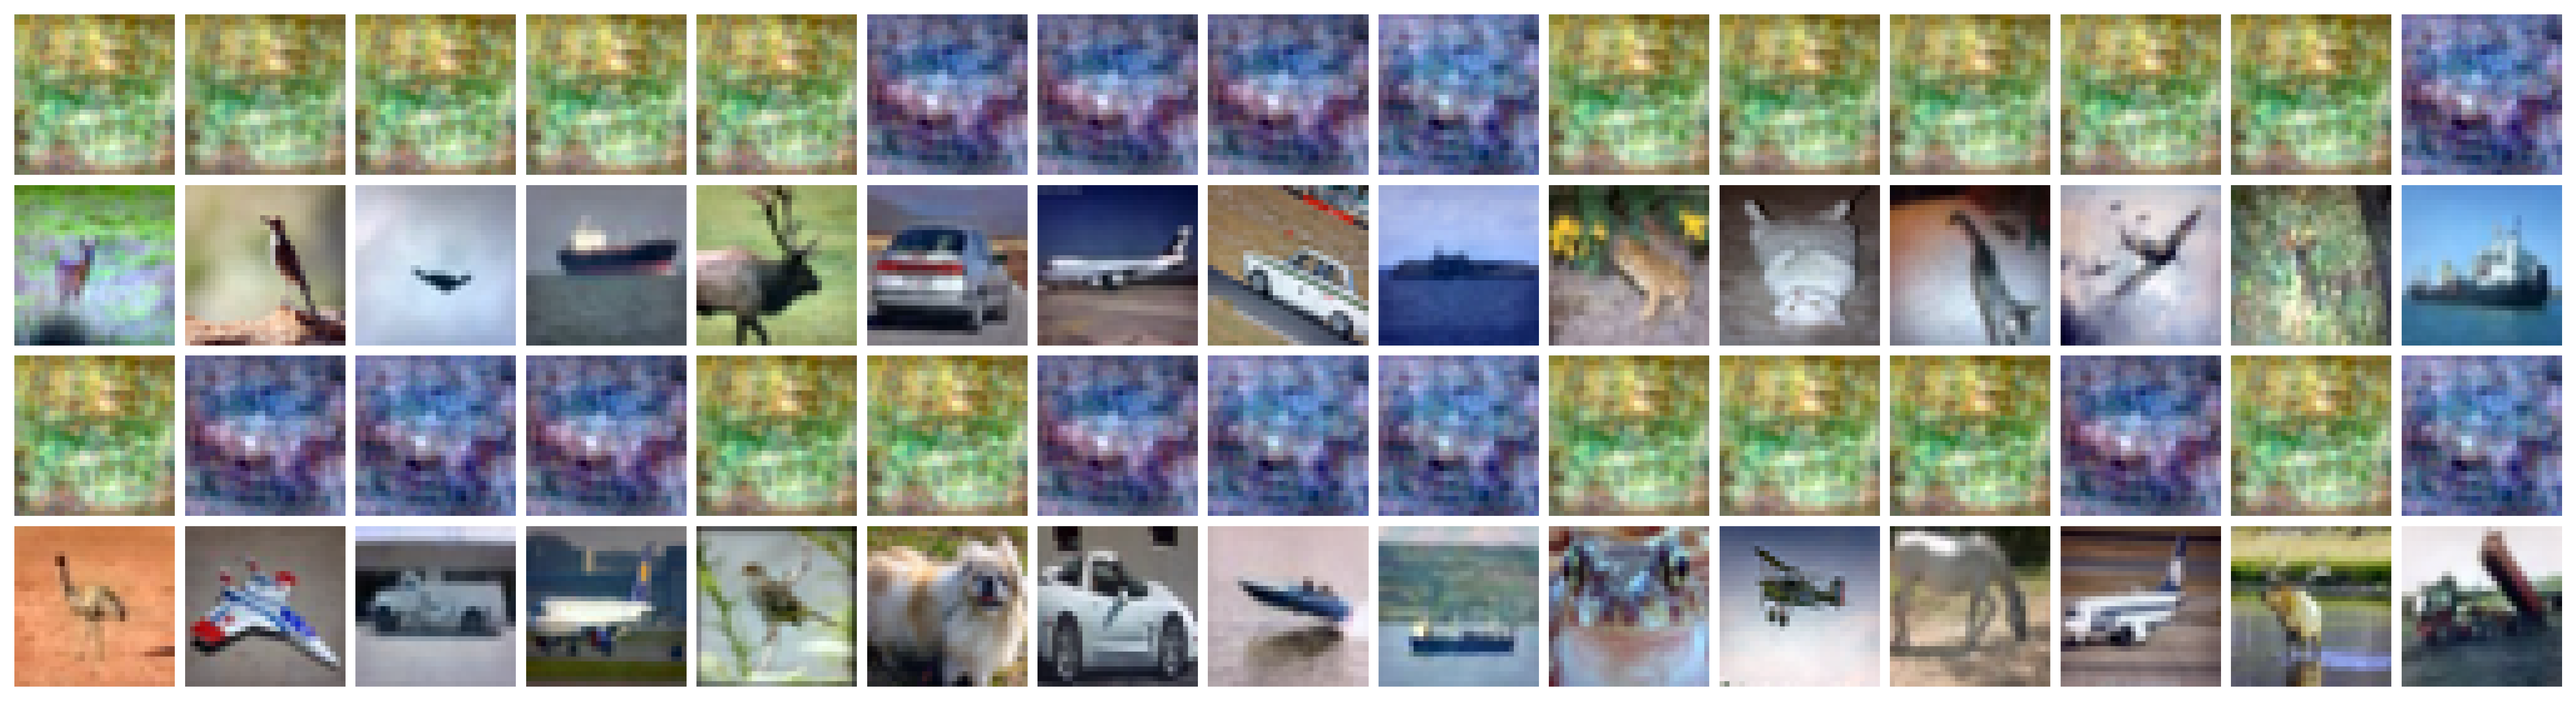

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_1250_run.png


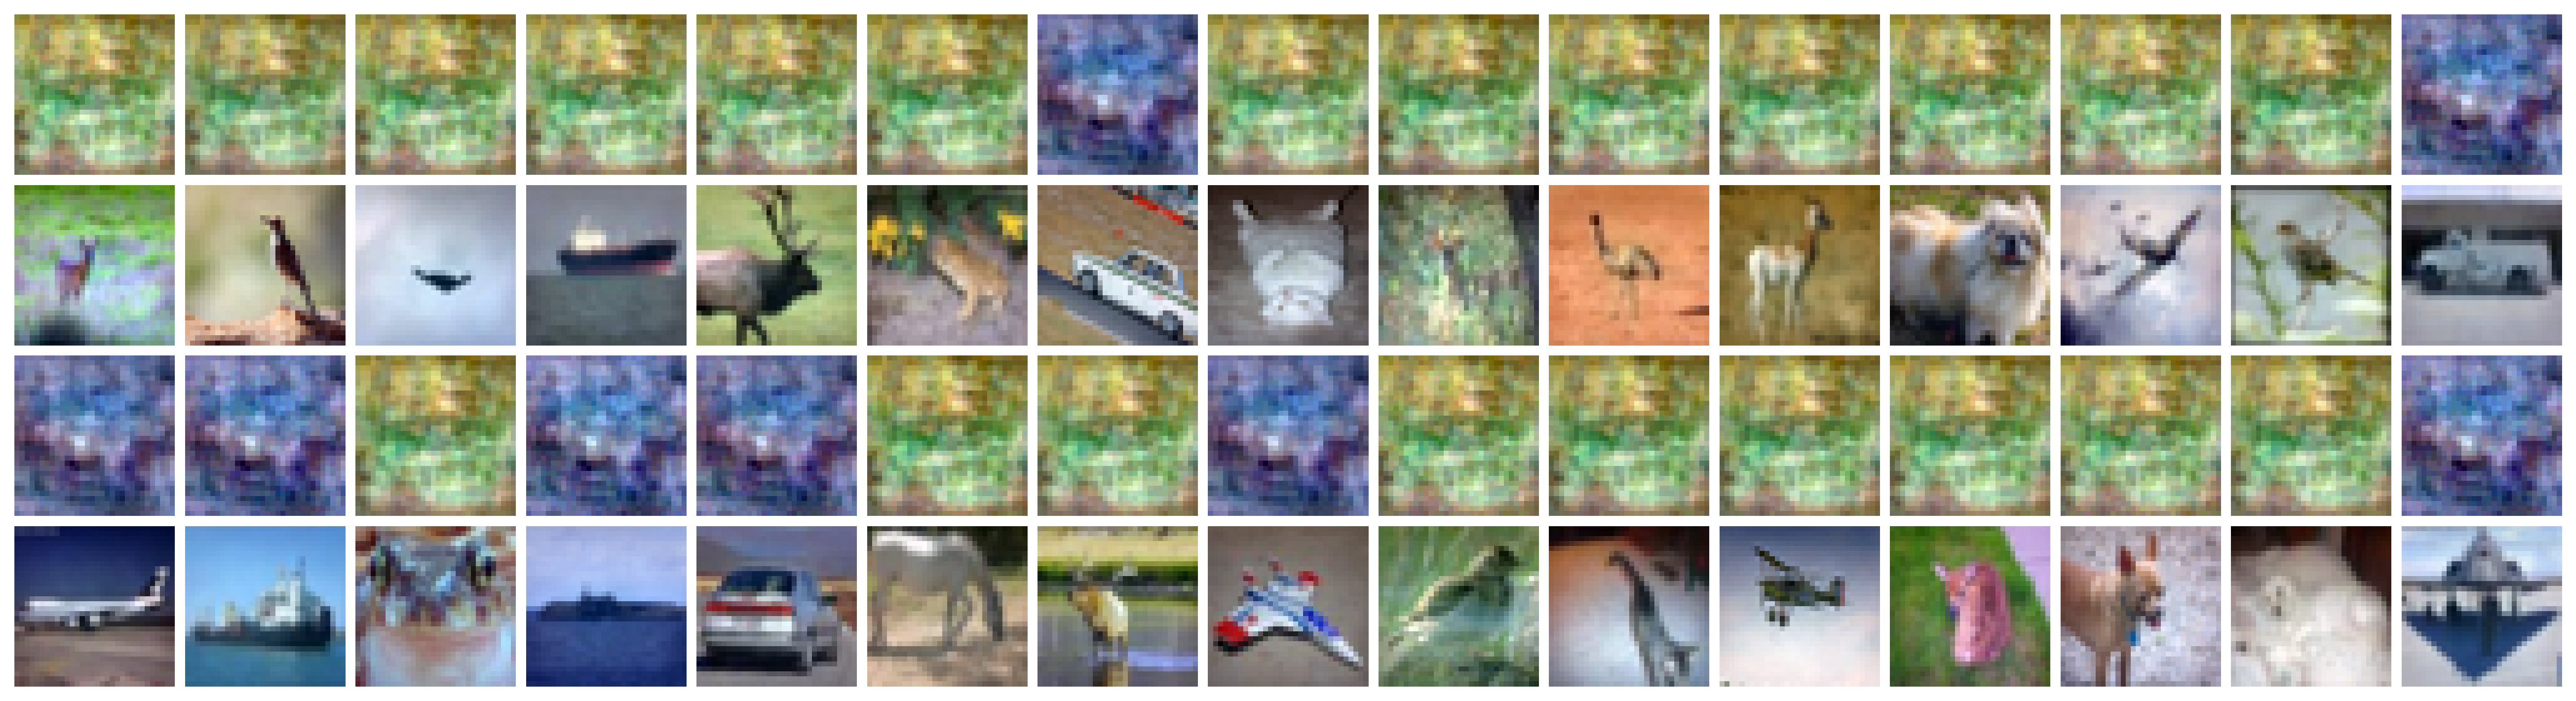

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_2500_run.png


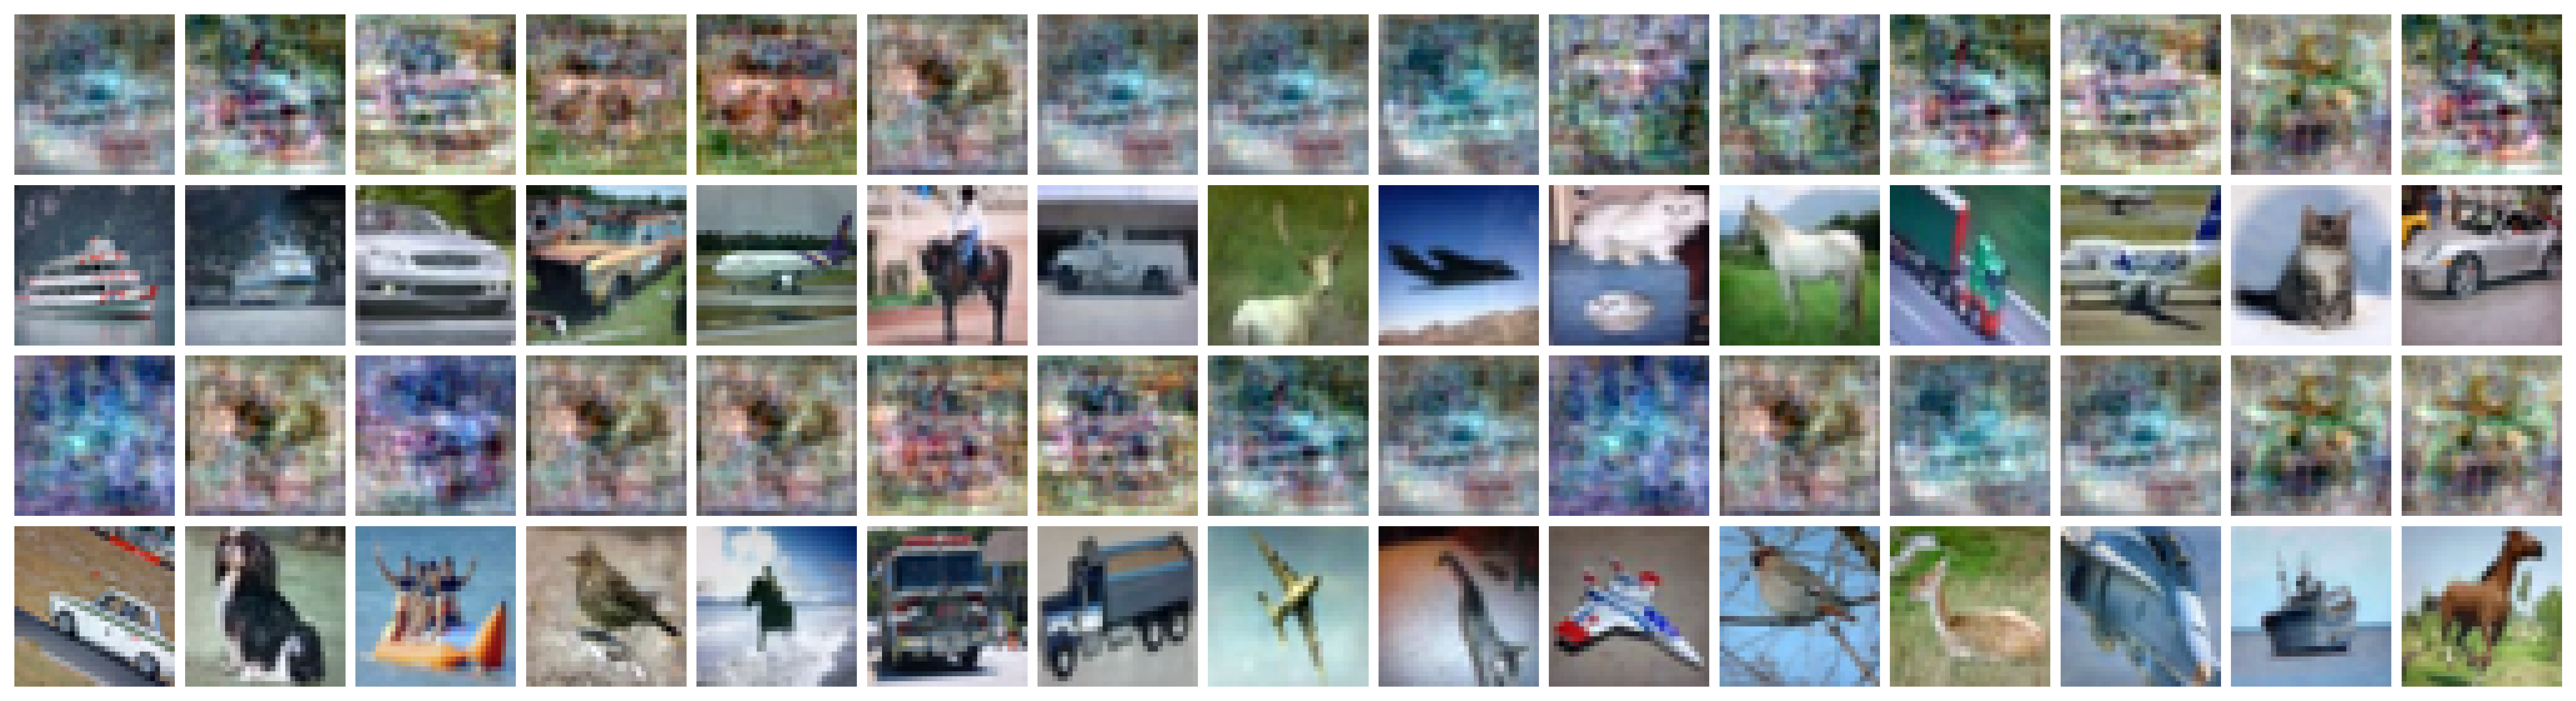

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_2500_run.png


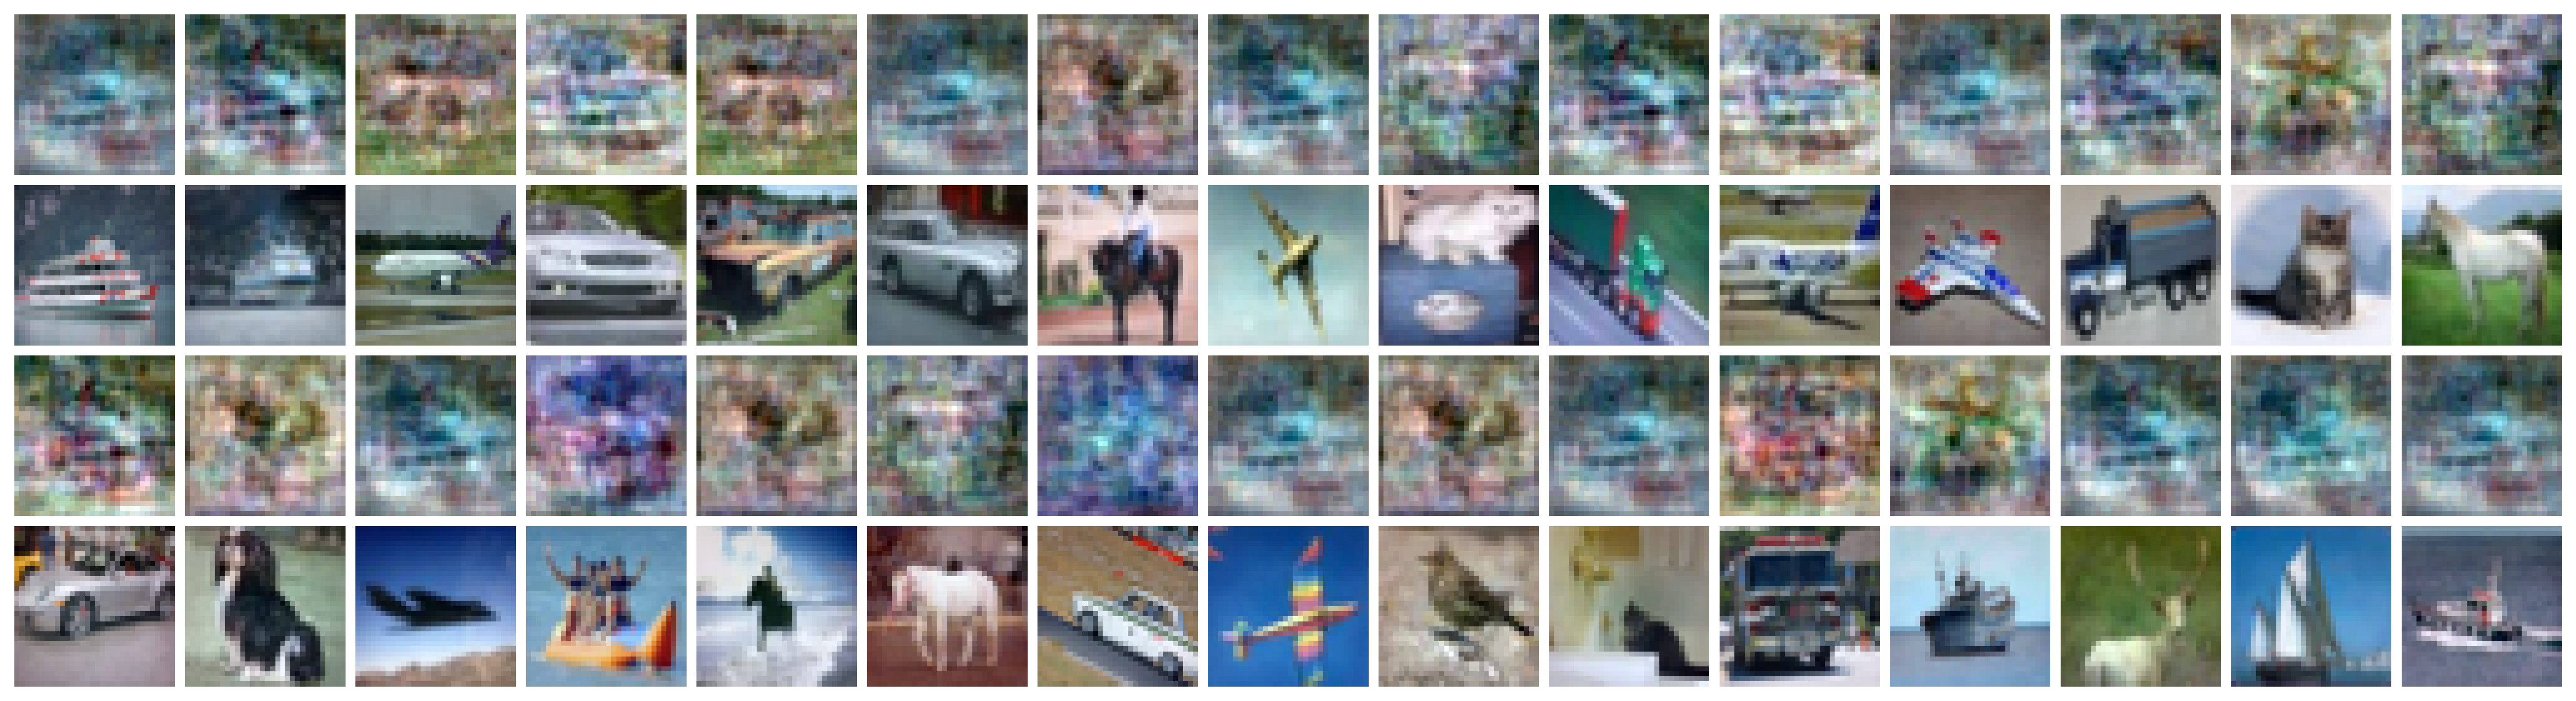

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_3750_run.png


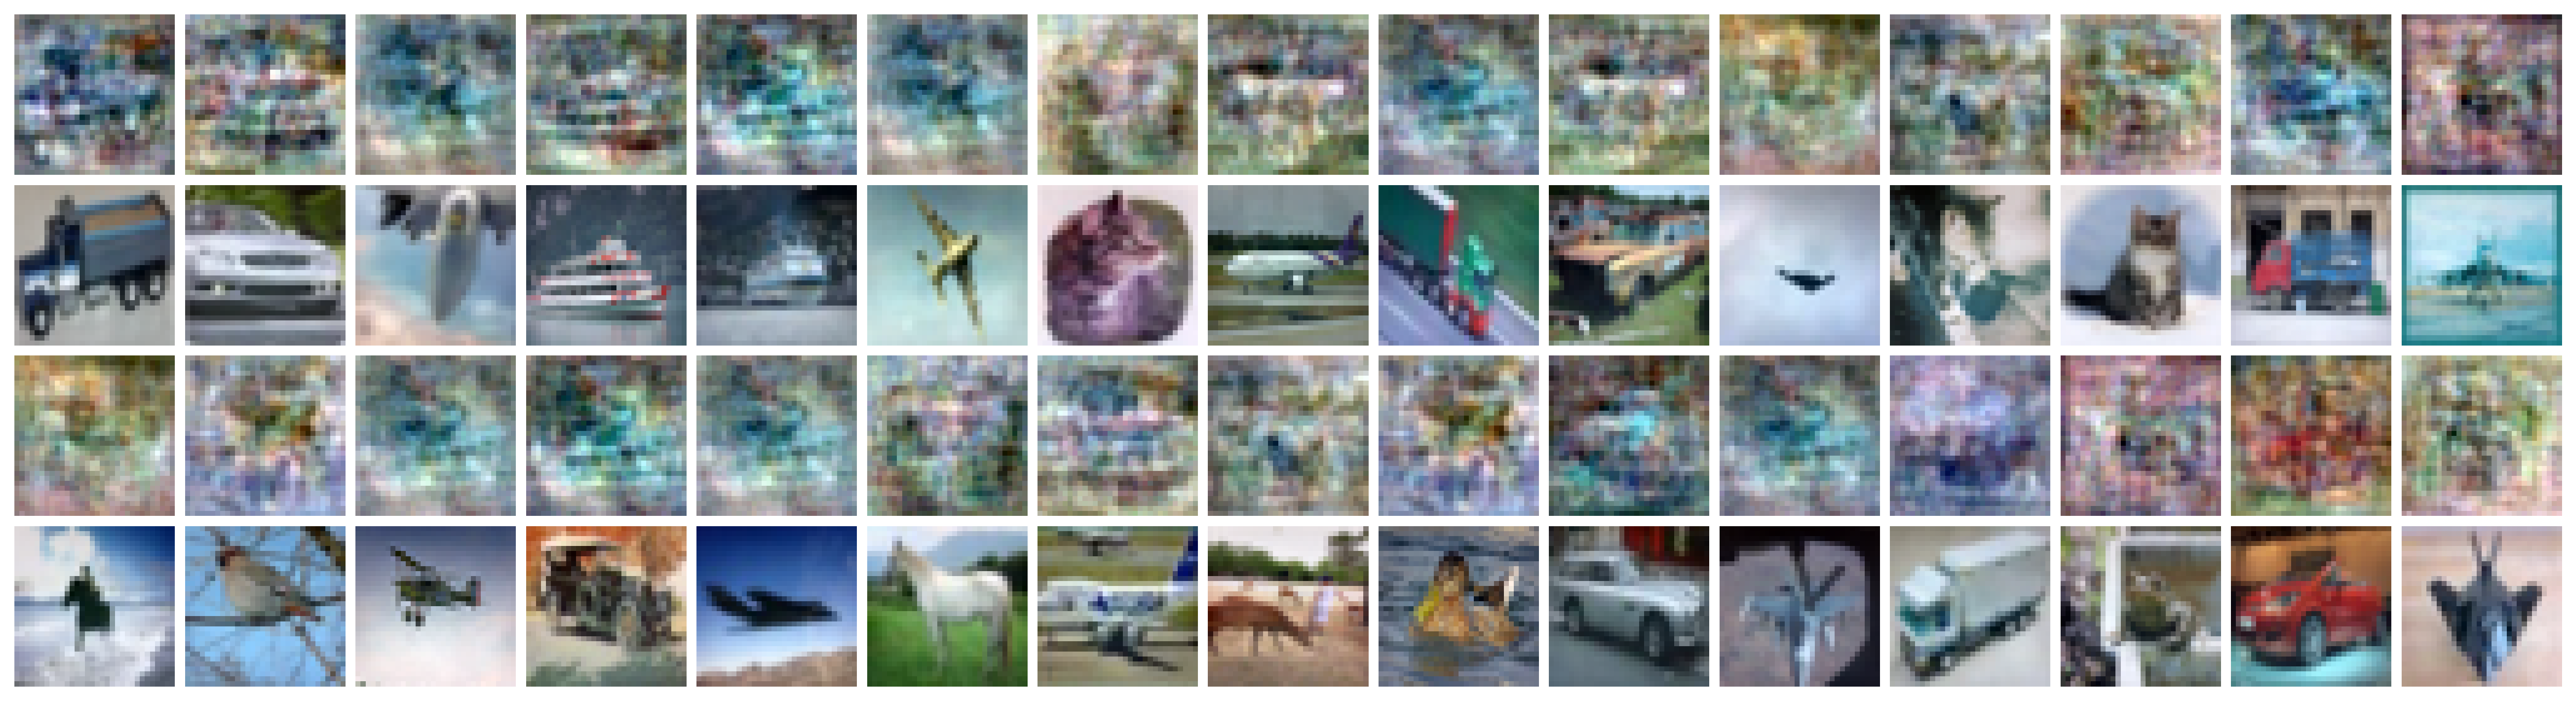

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_3750_run.png


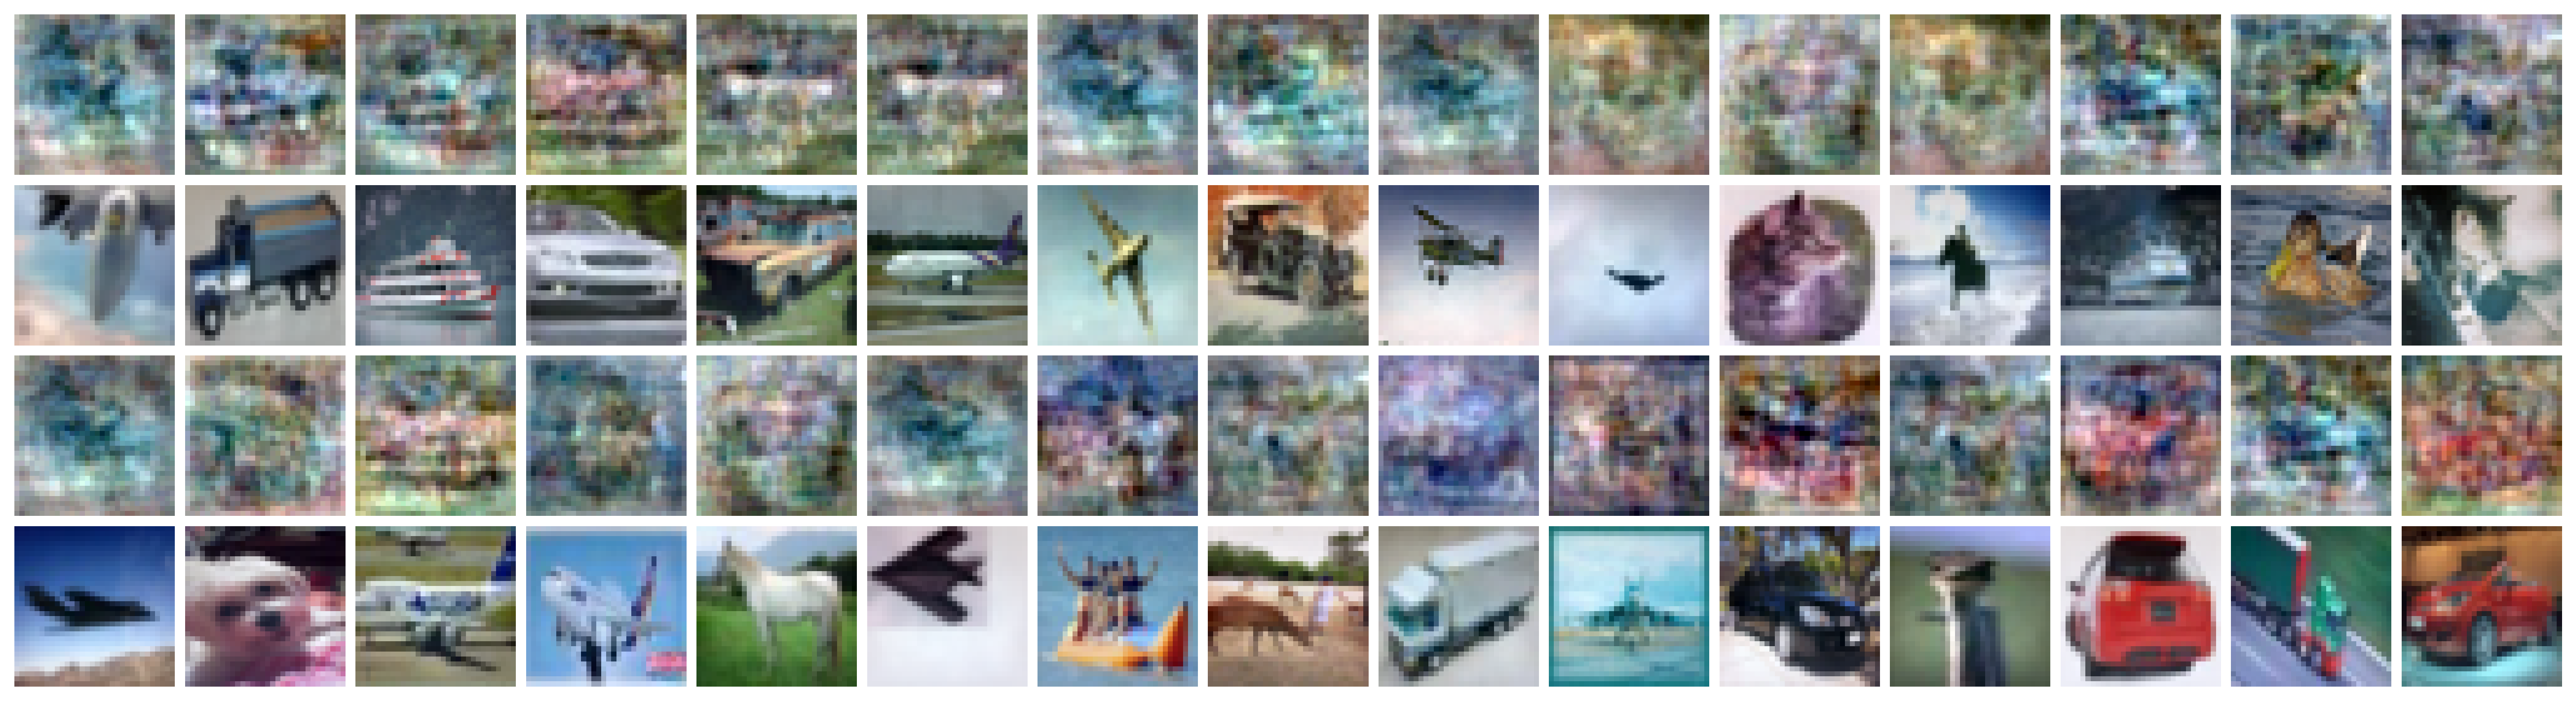

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_5000_run.png


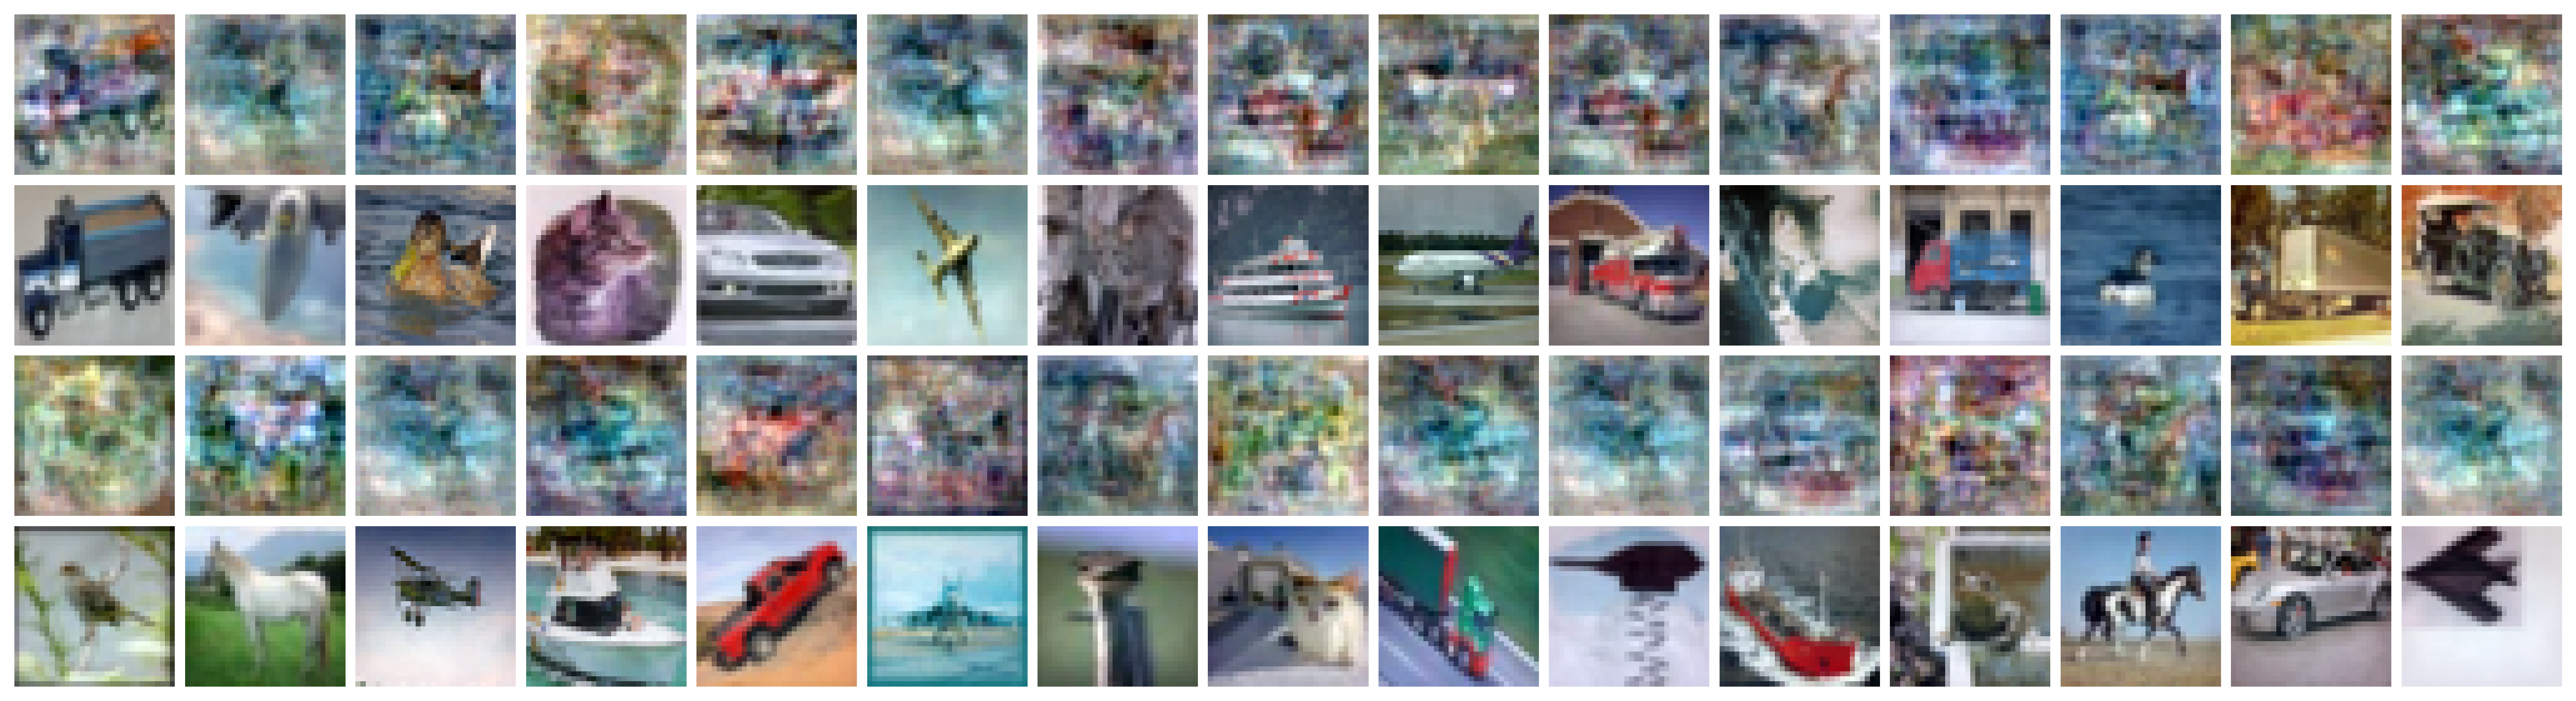

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_5000_run.png


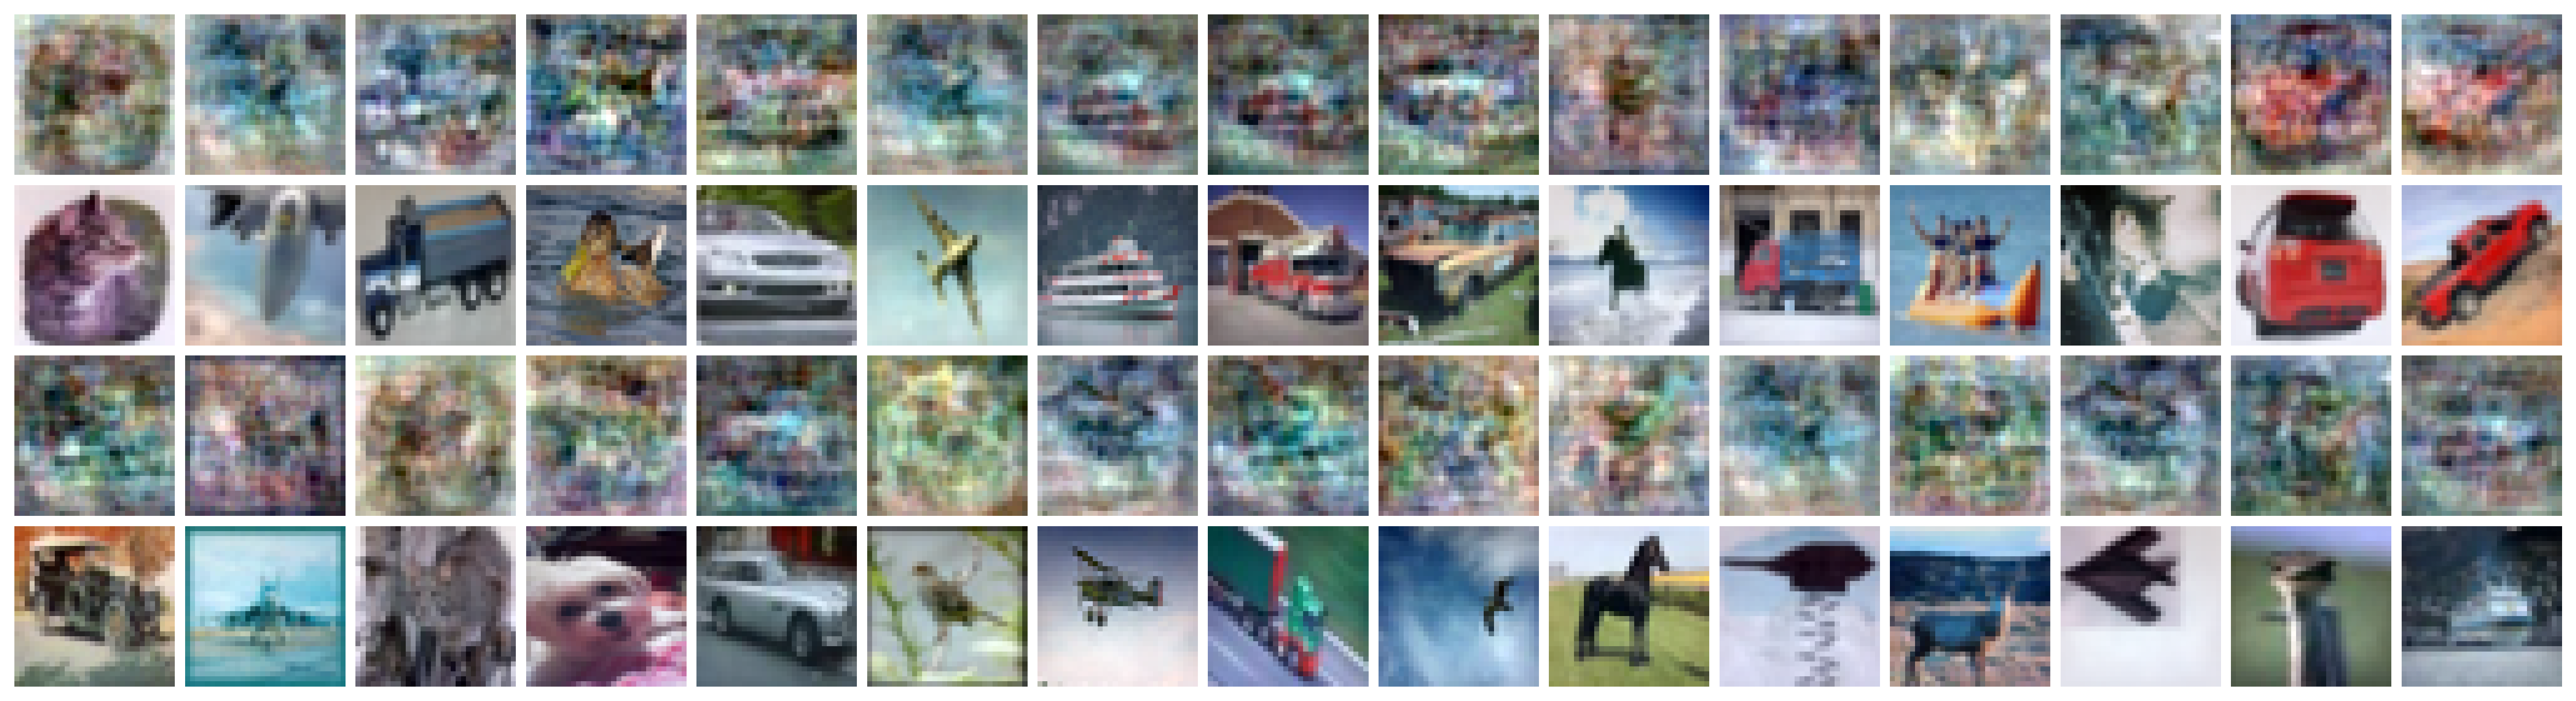

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_6250_run.png


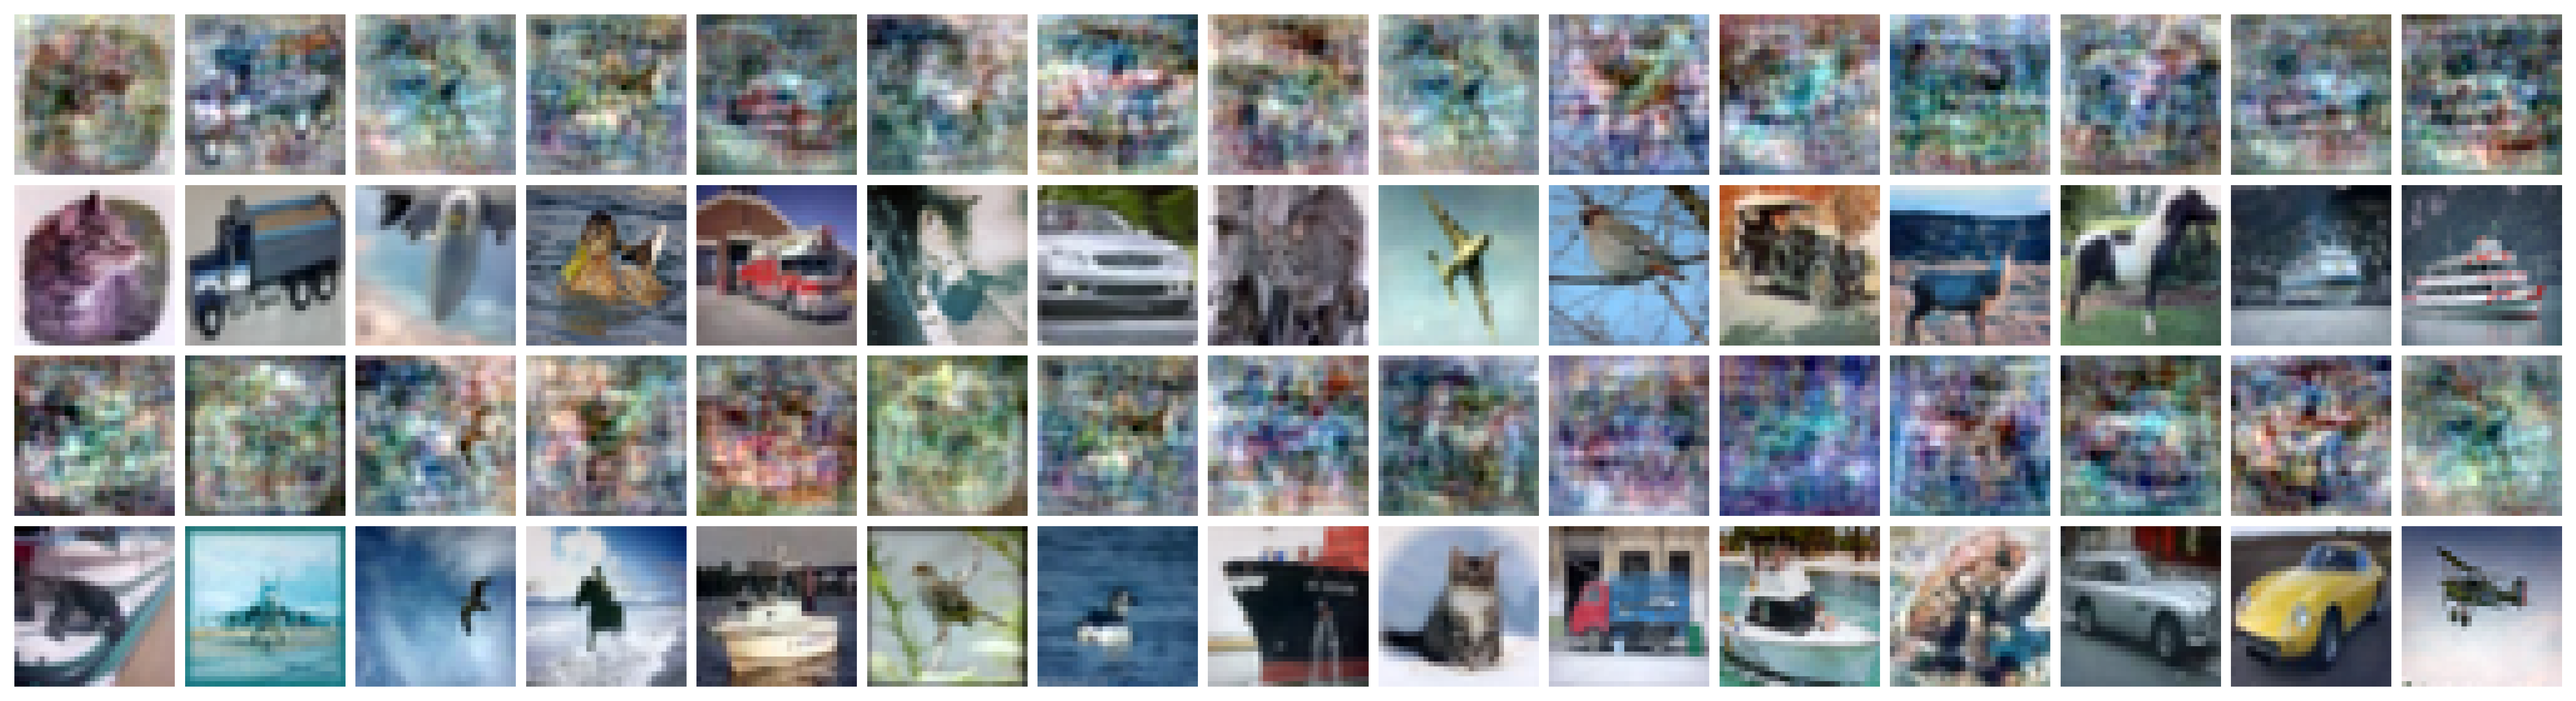

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_6250_run.png


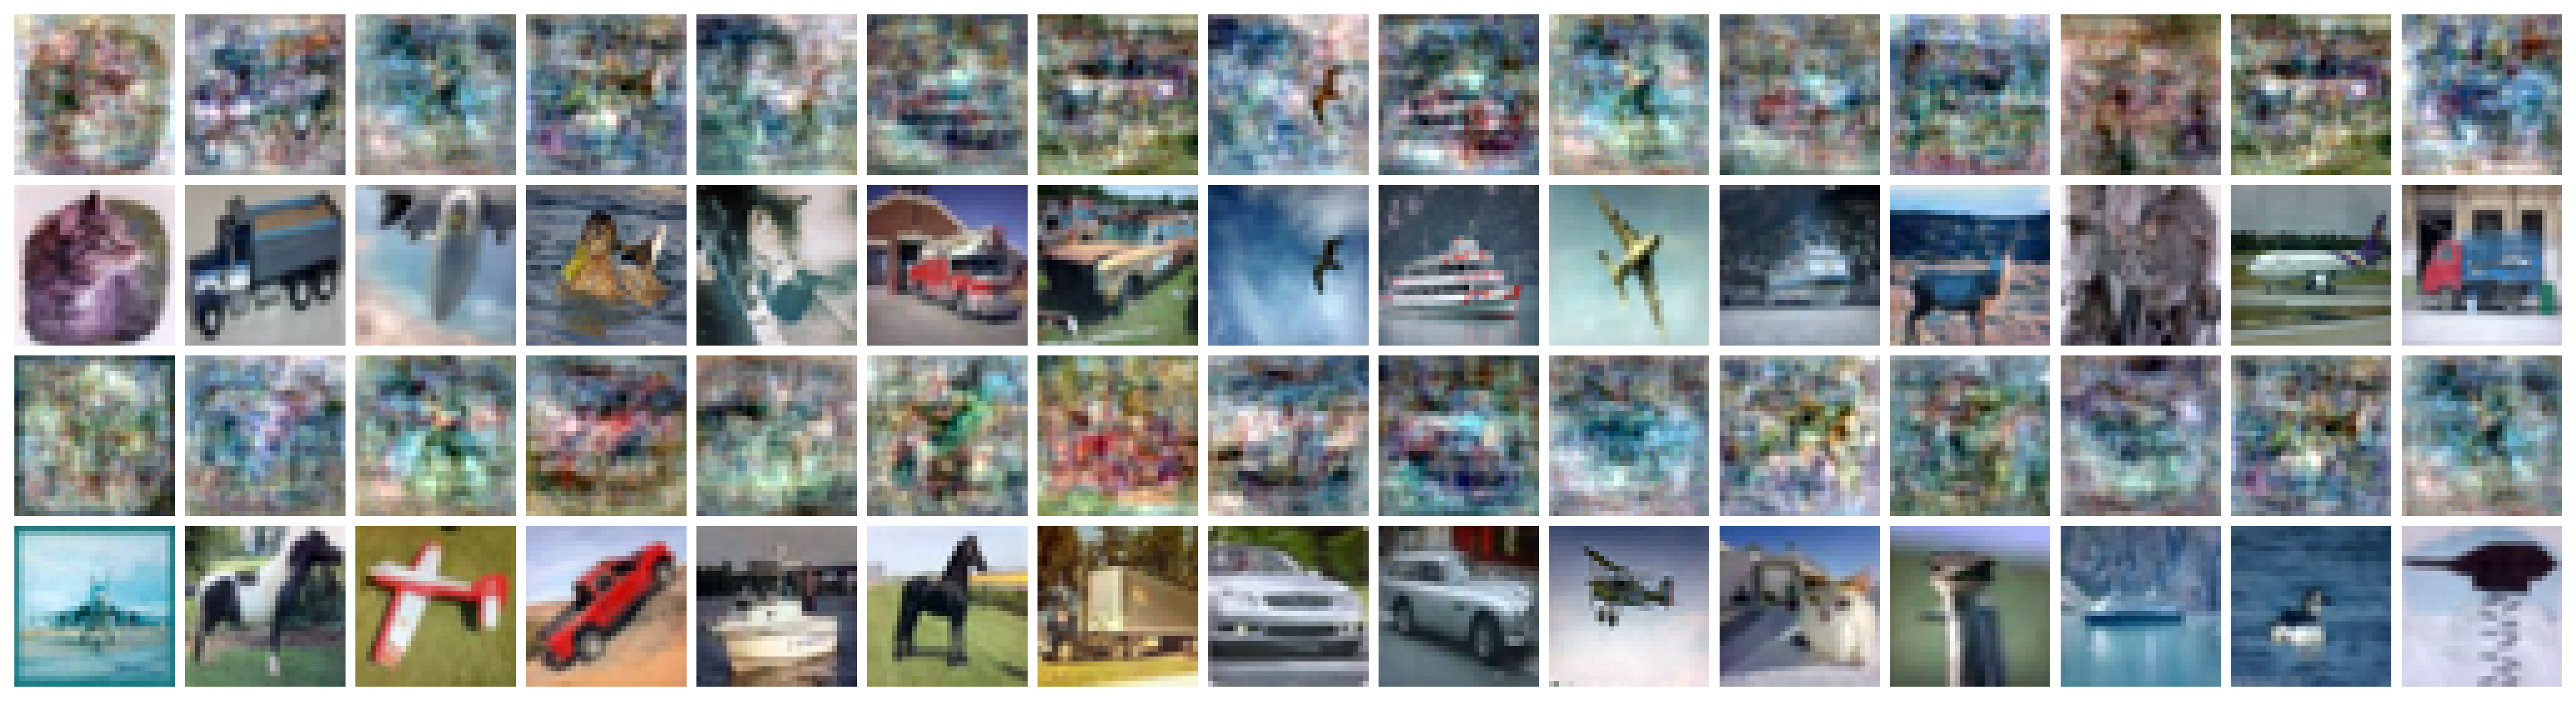

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_7500_run.png


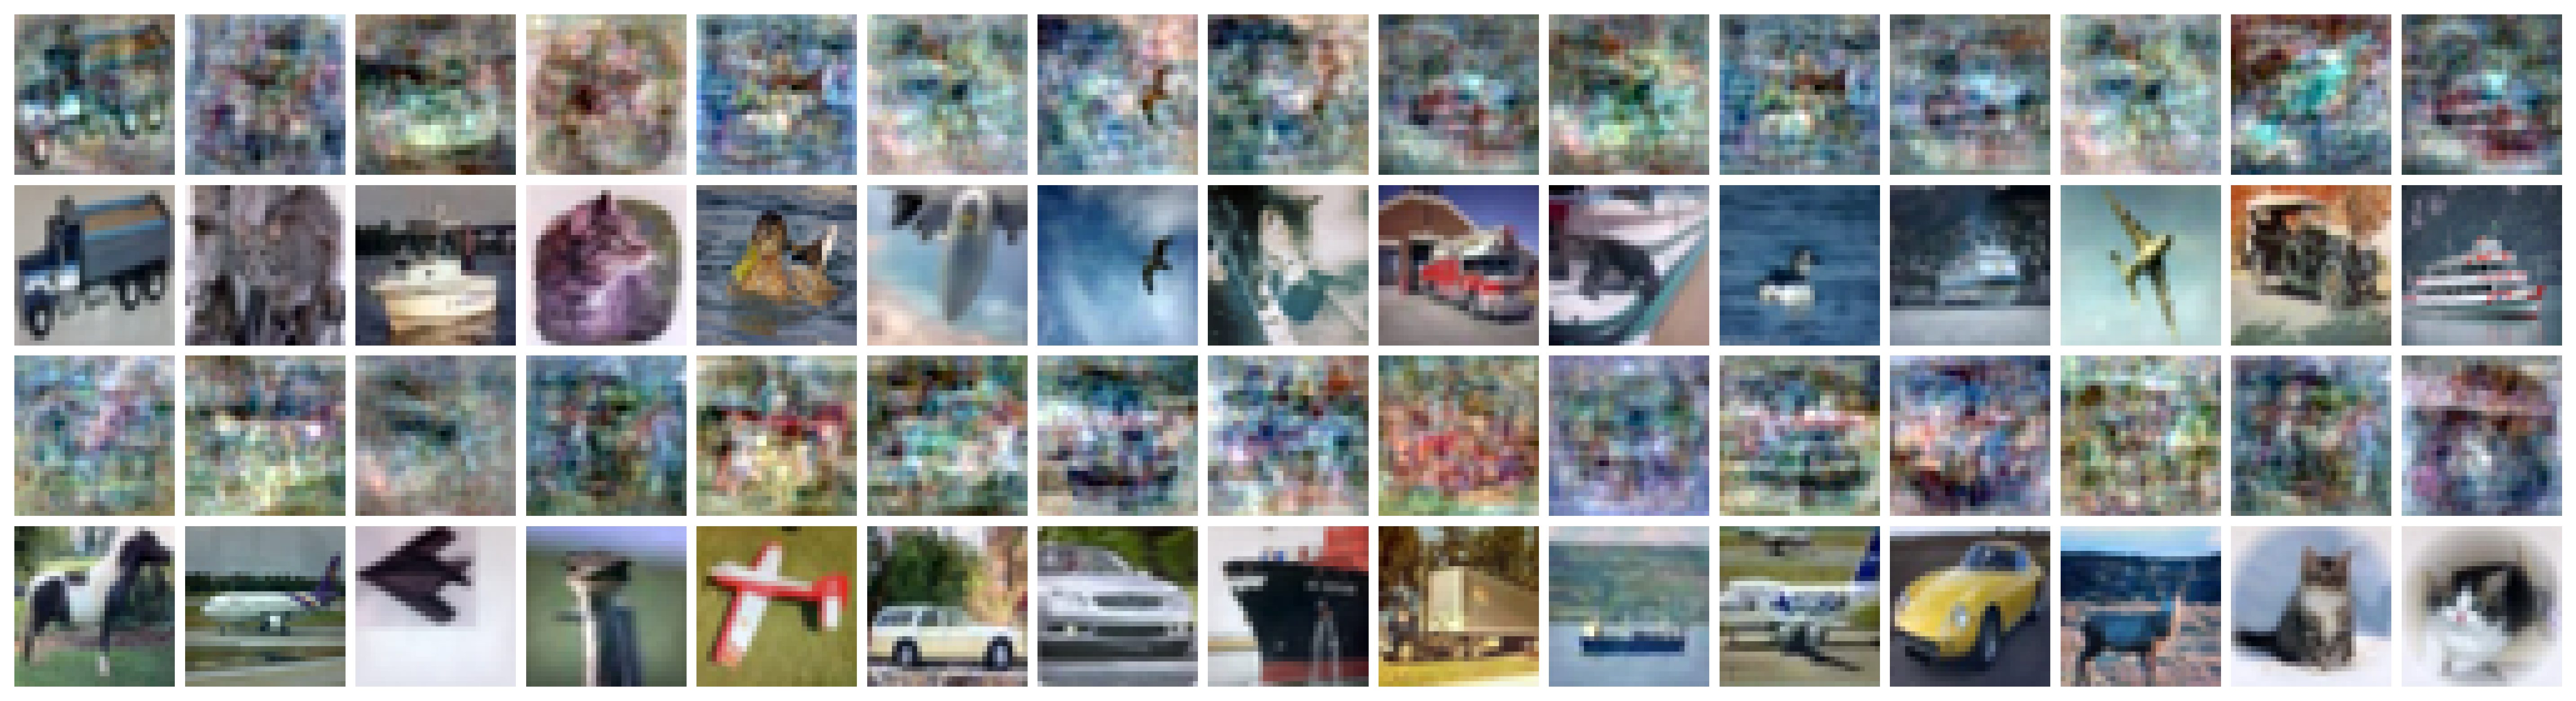

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_7500_run.png


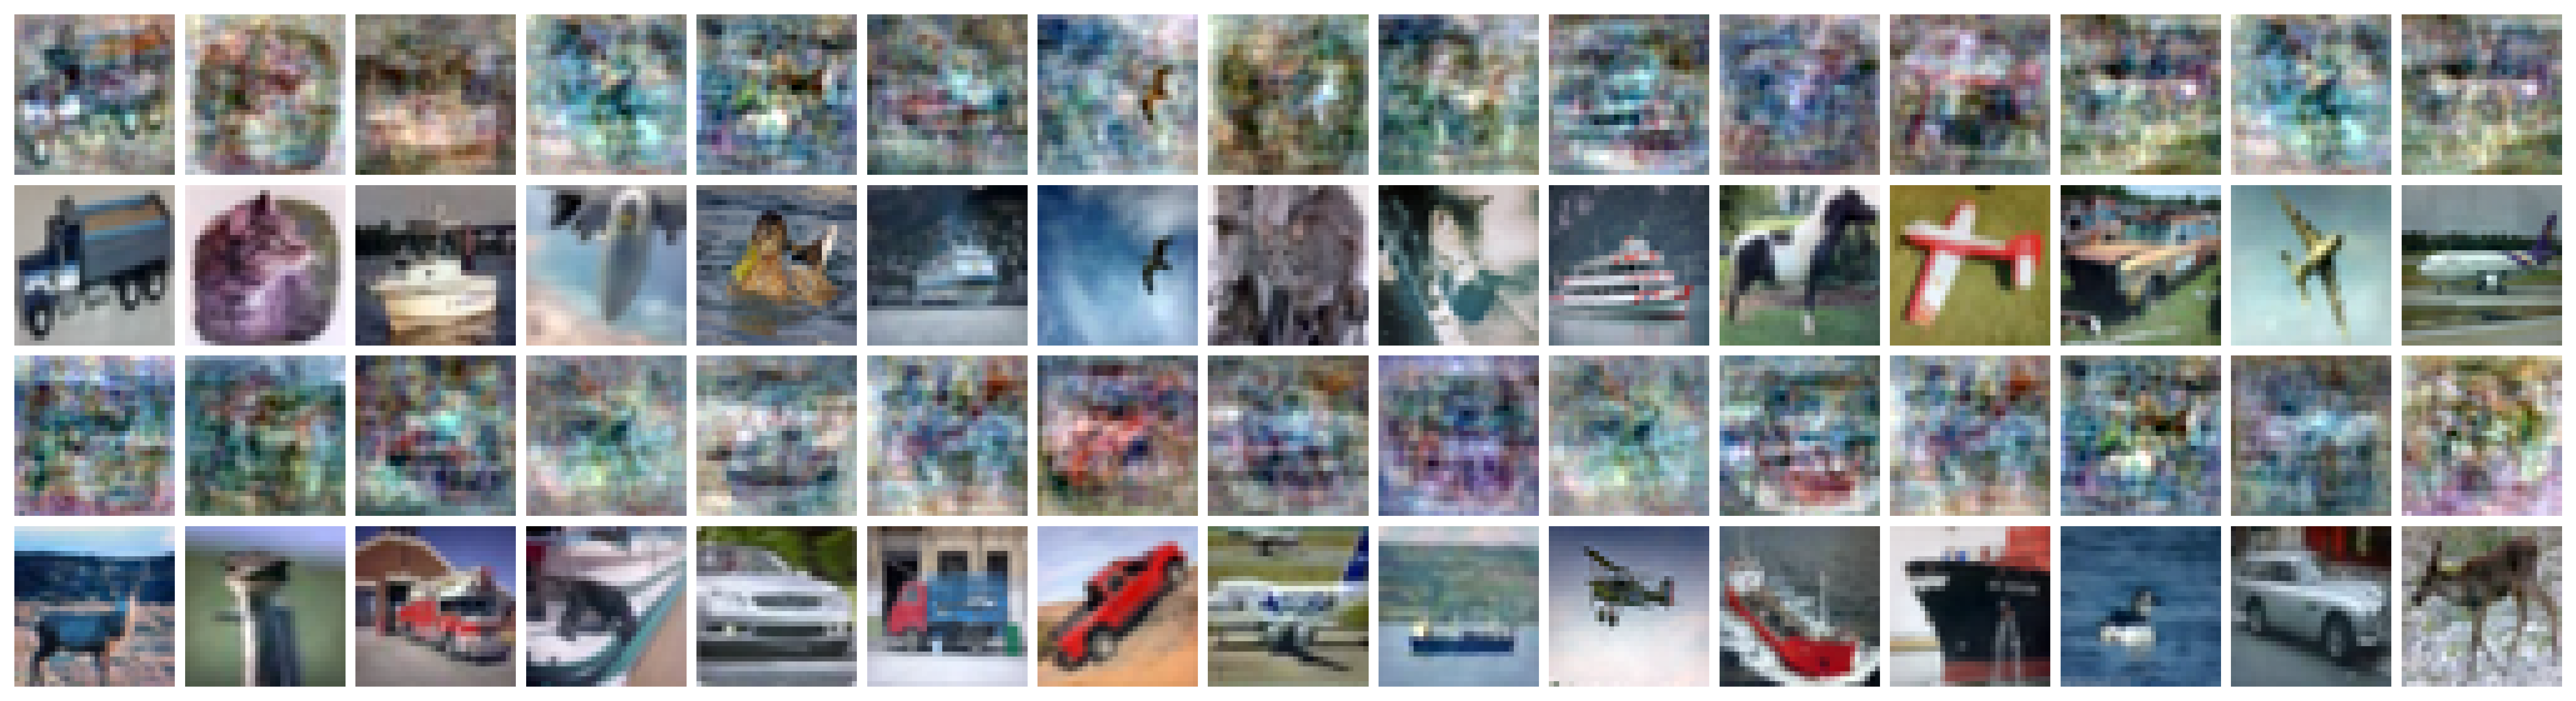

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_8750_run.png


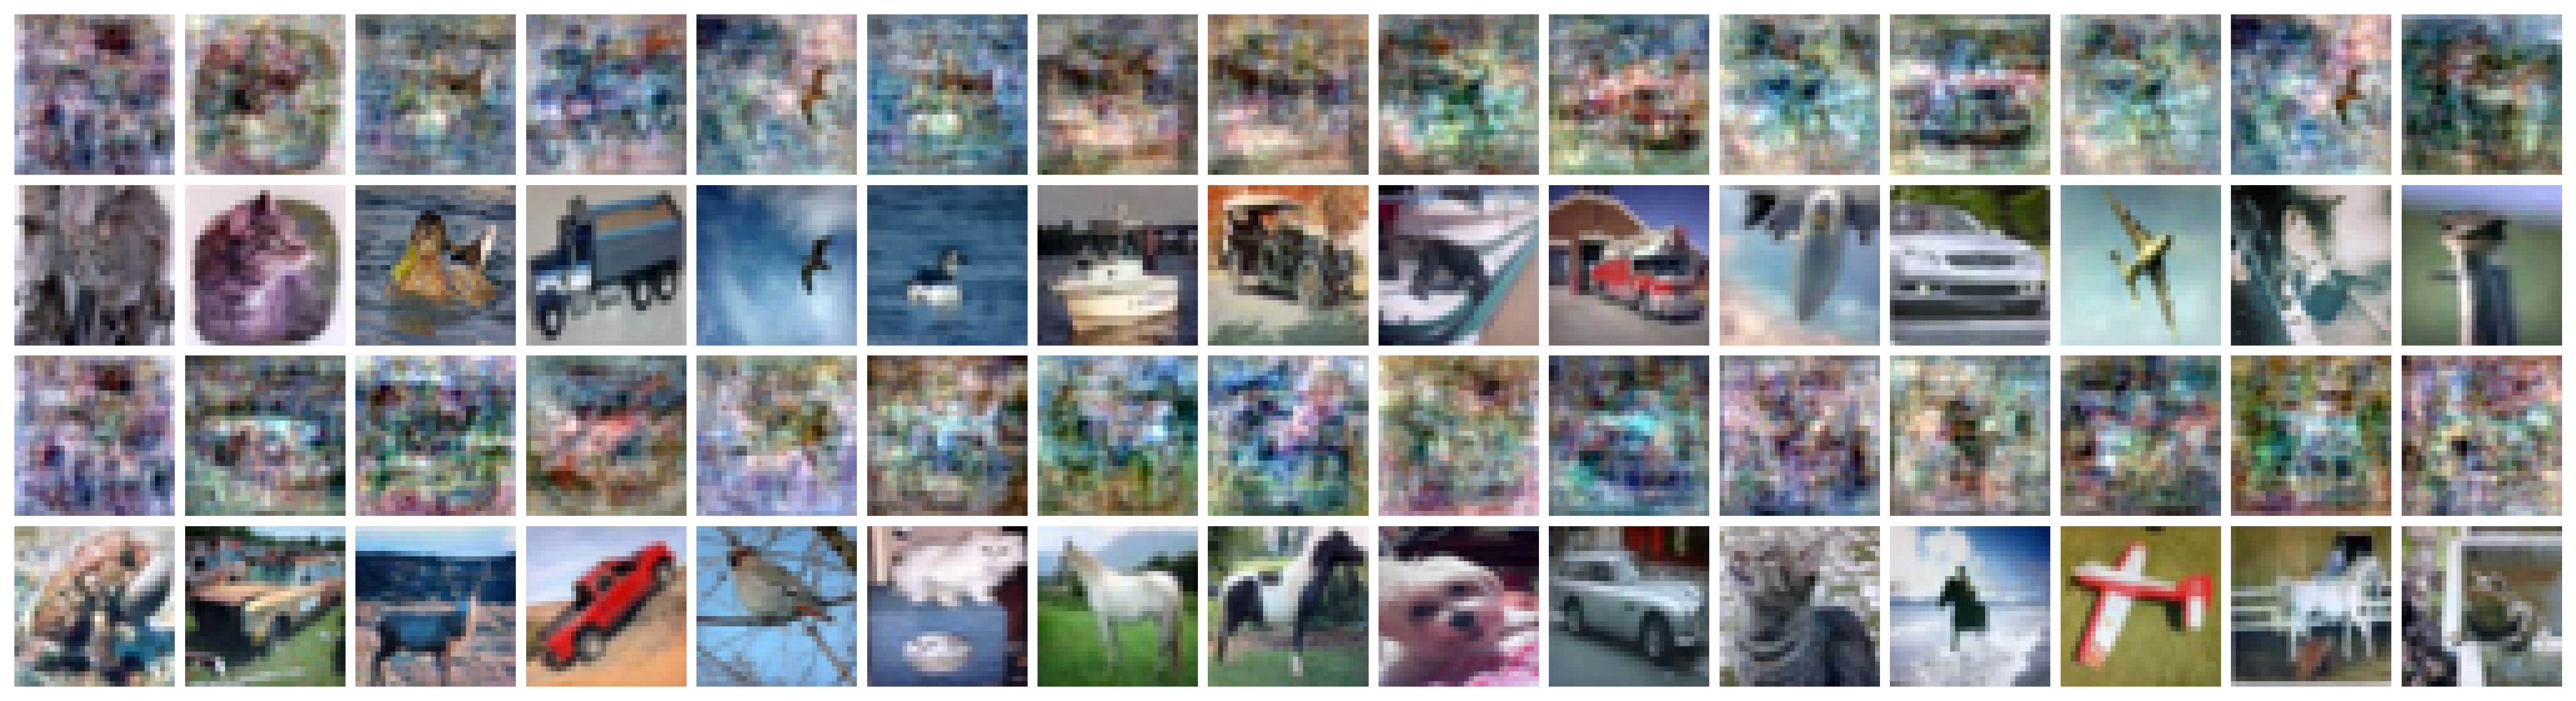

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_8750_run.png


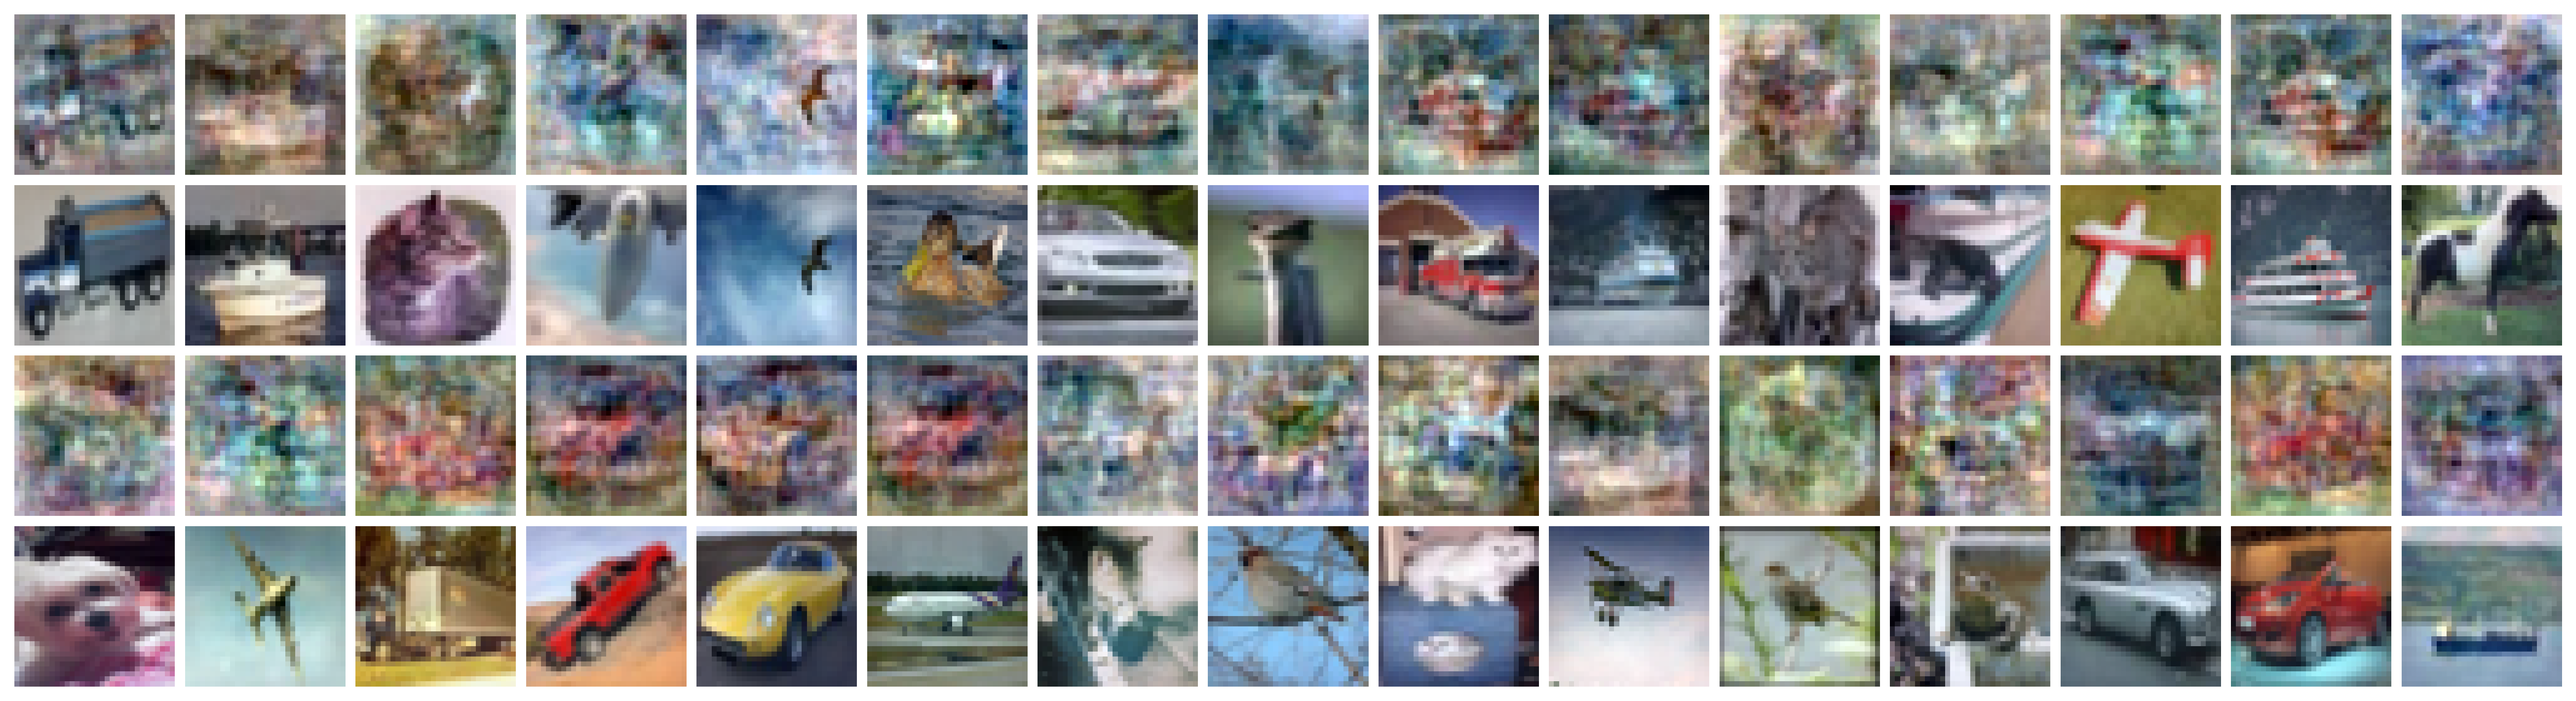

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_10000_run.png


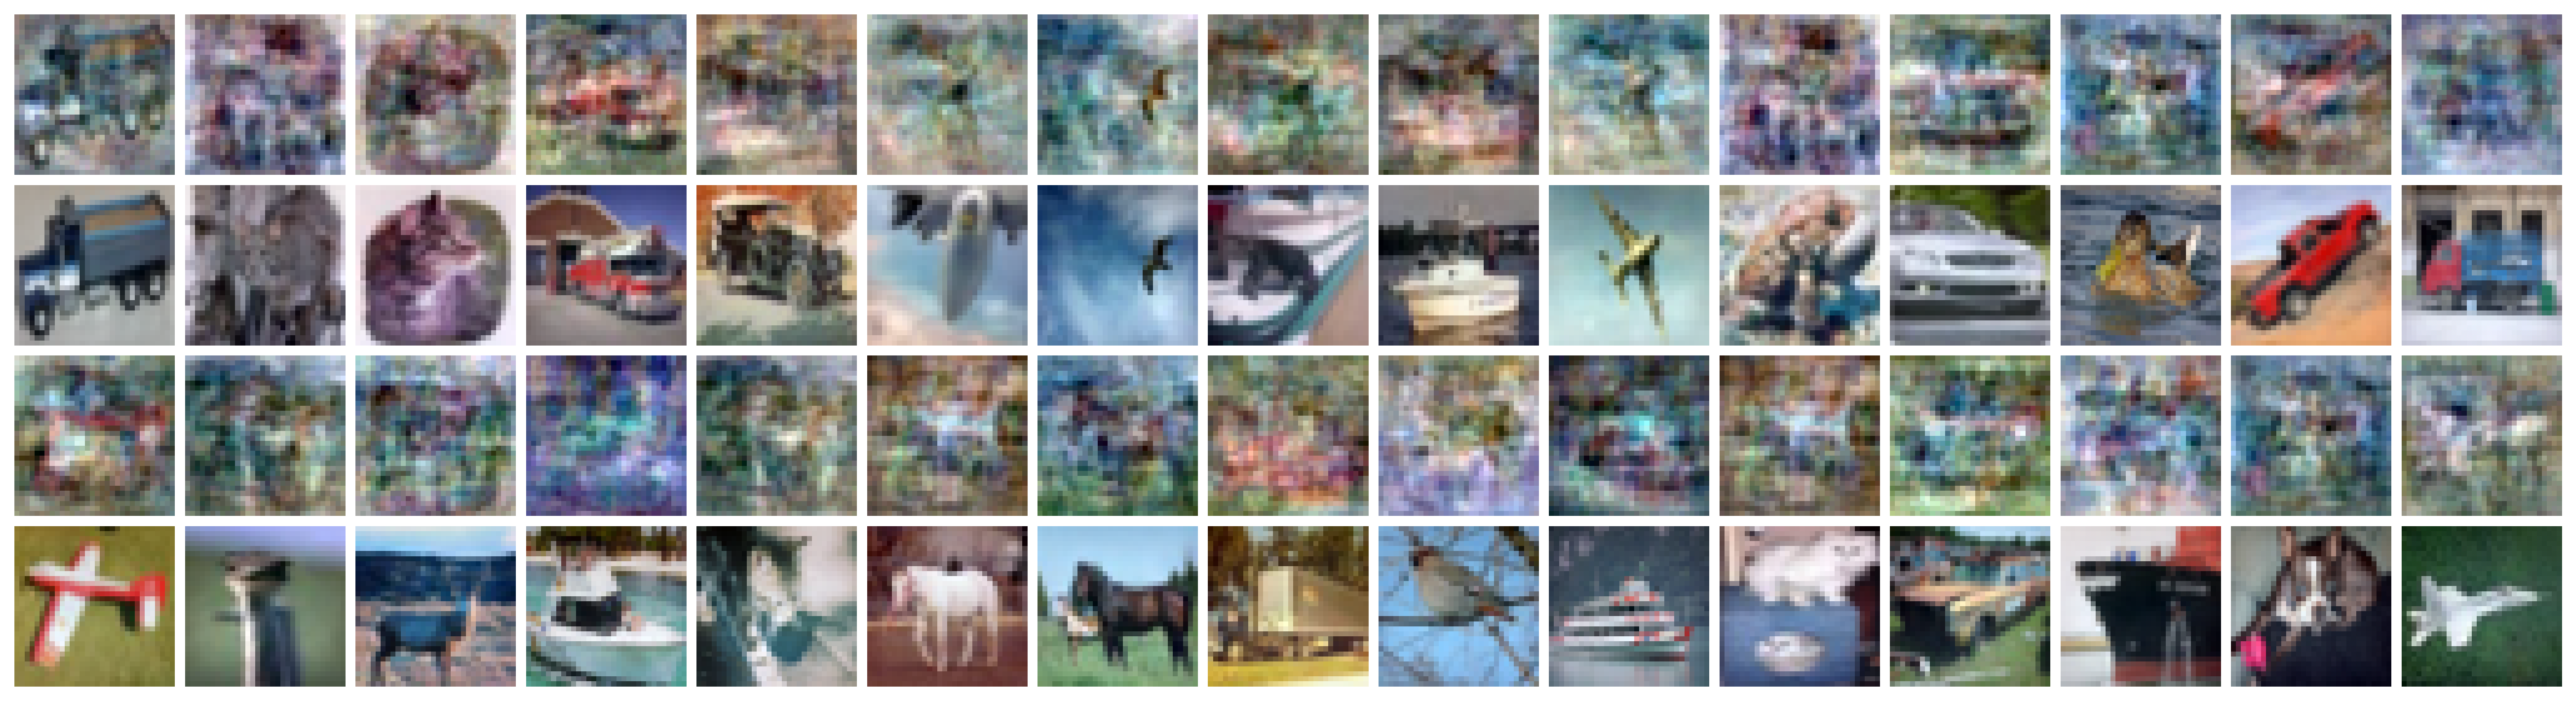

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_10000_run.png


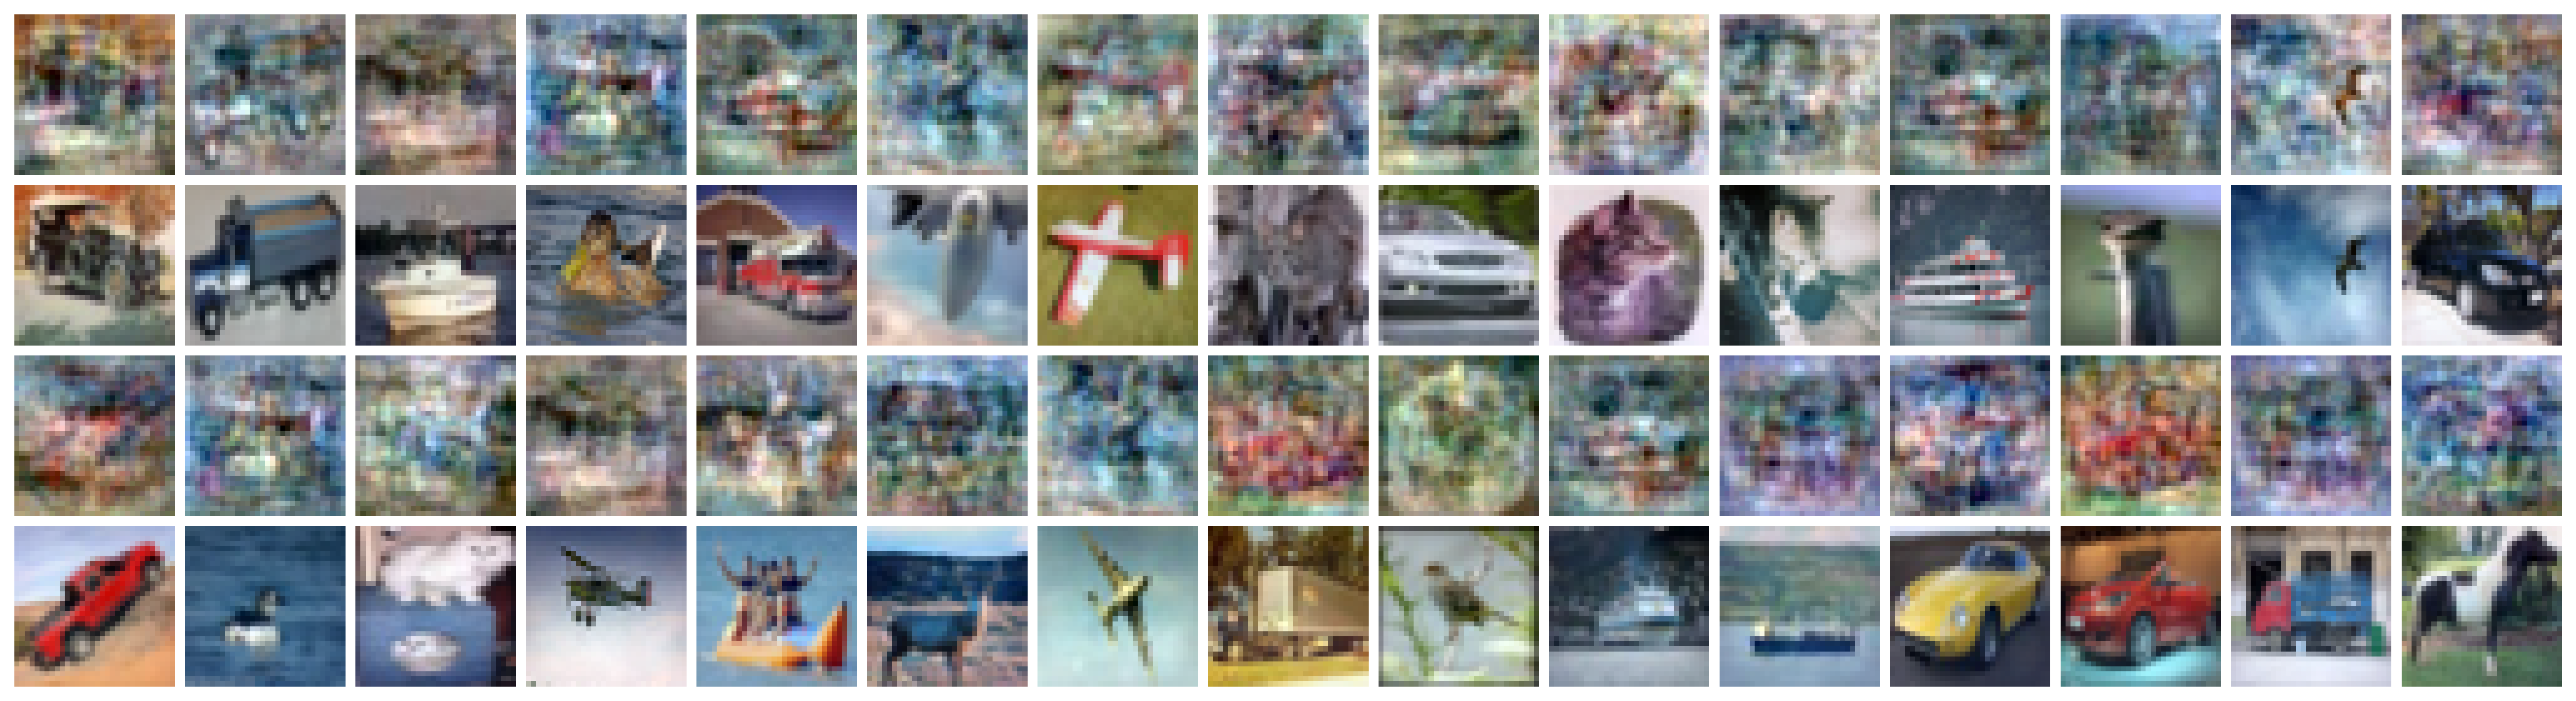

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_11250_run.png


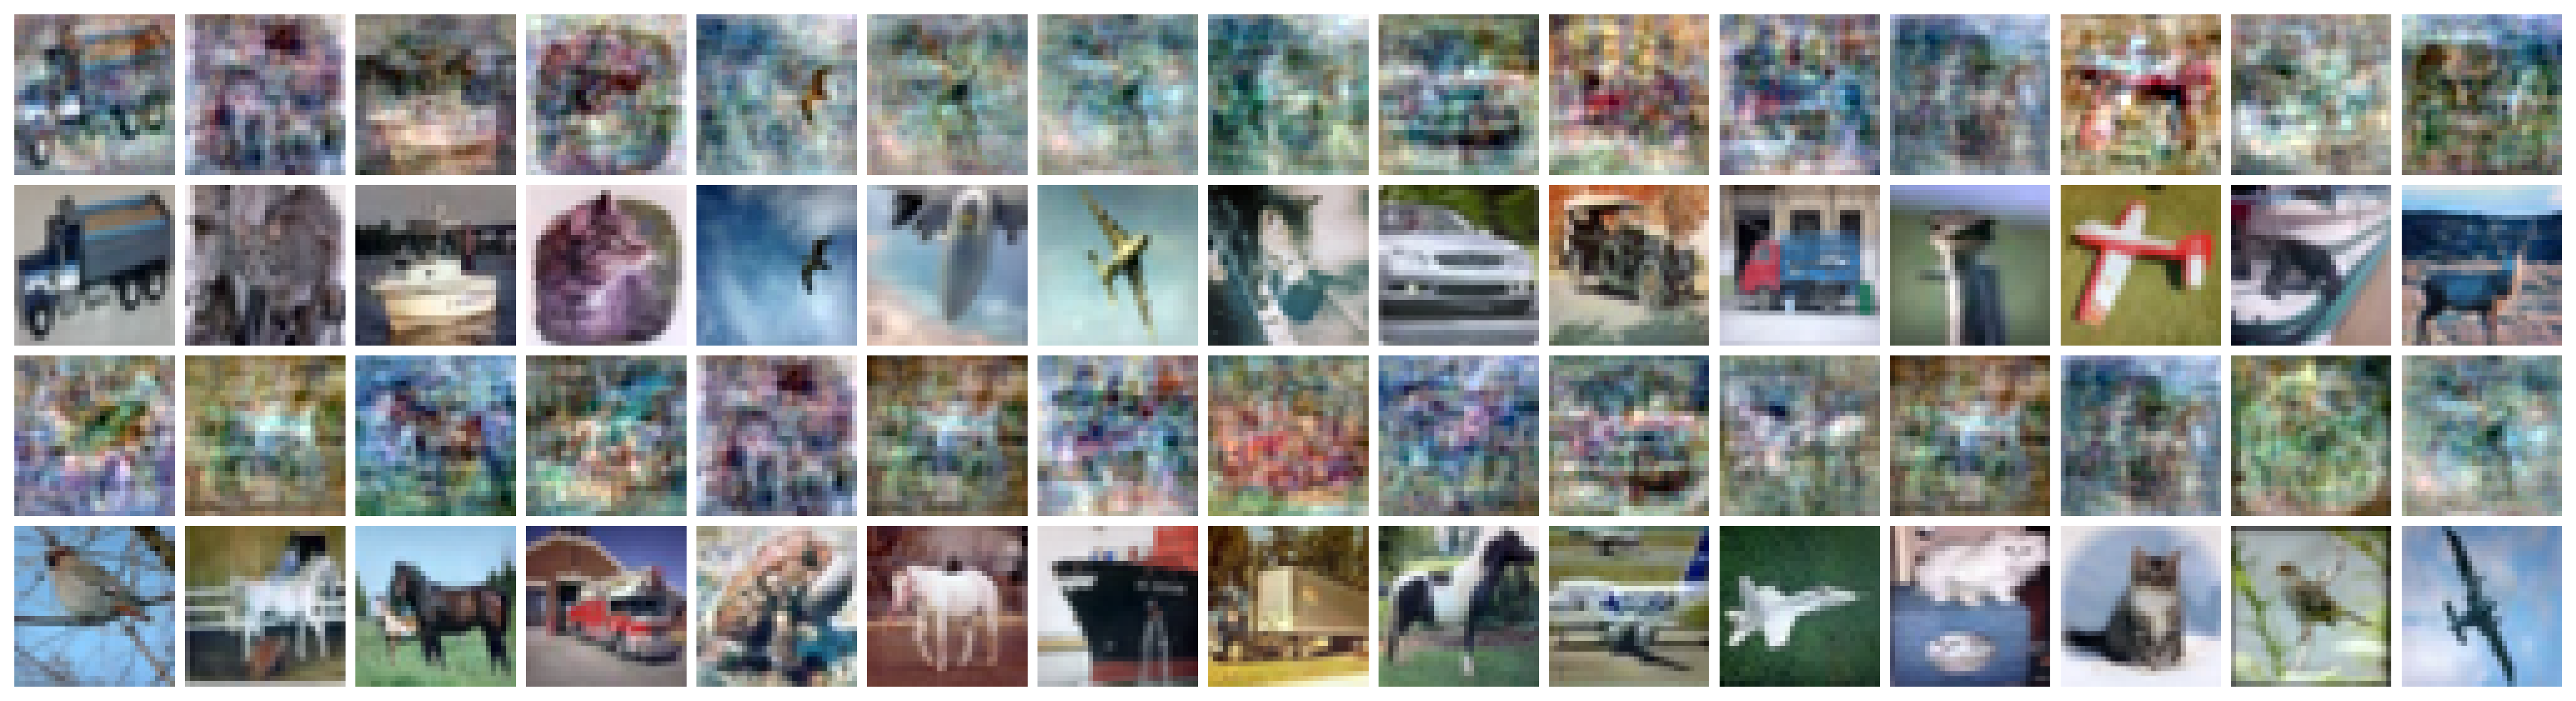

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_11250_run.png


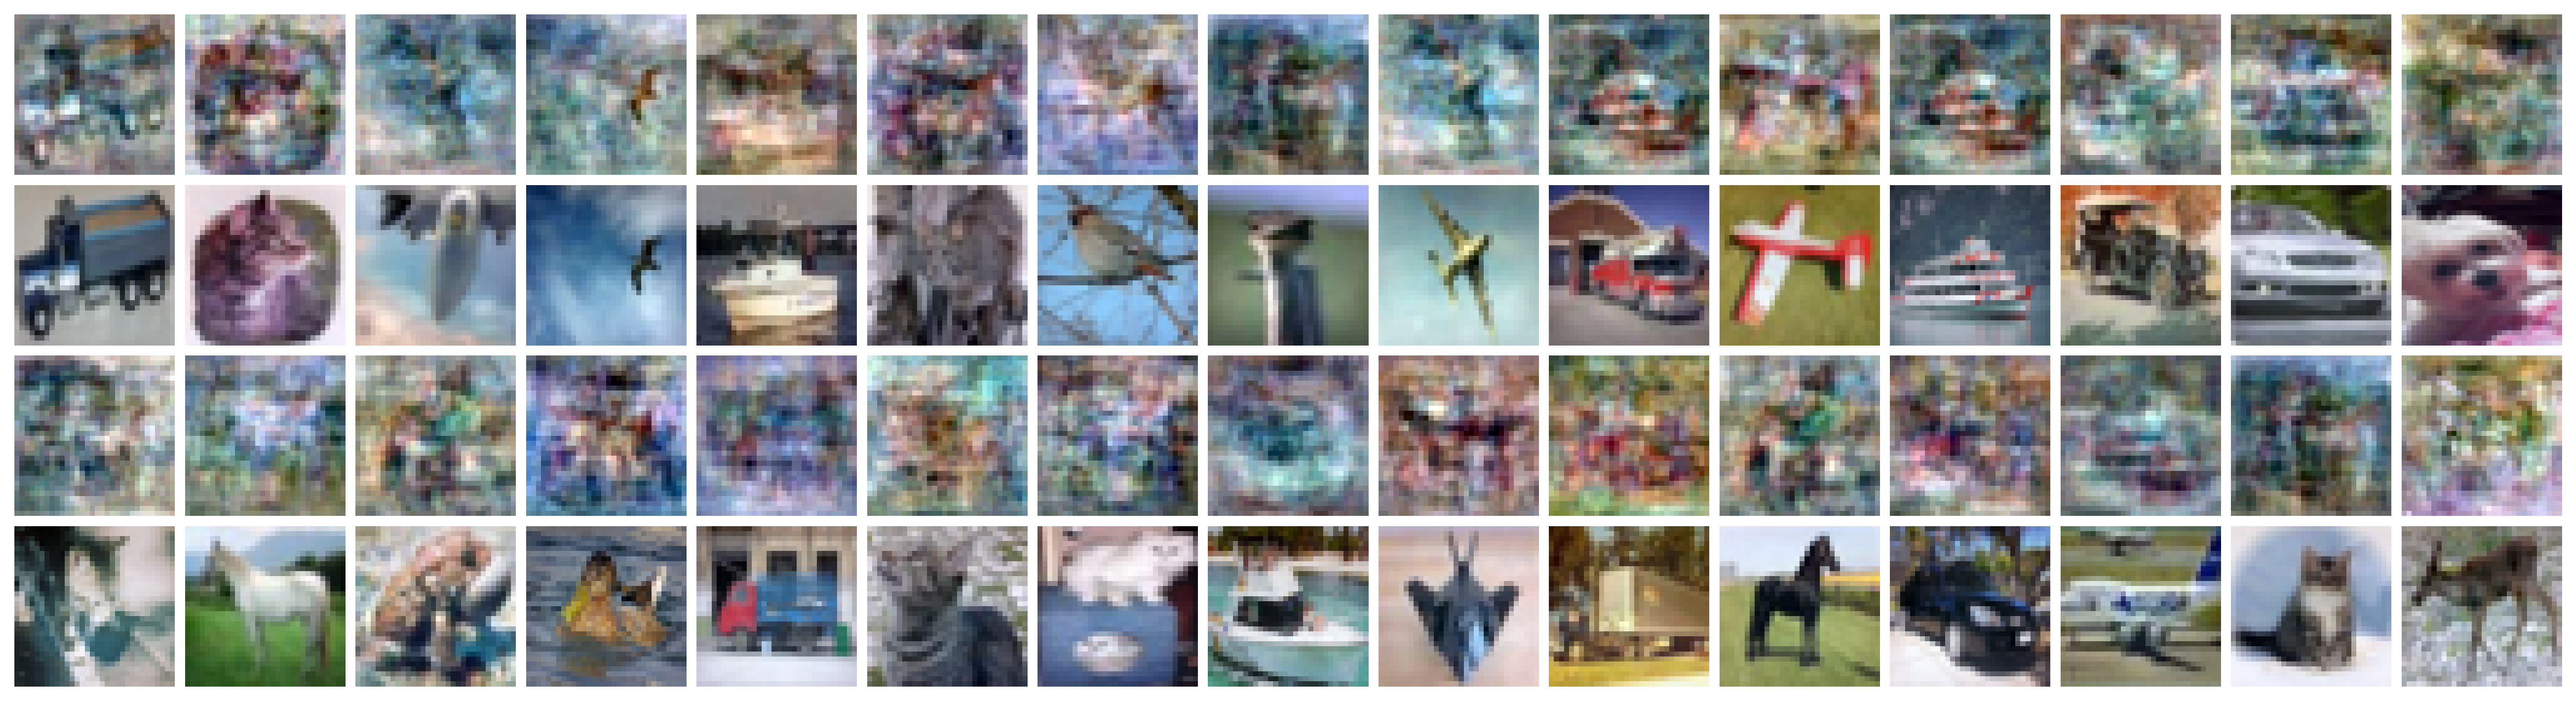

DONE!
loaded test.args.seed = 621
Reconstruction visualization of model trained with standard loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_std_12500_run.png


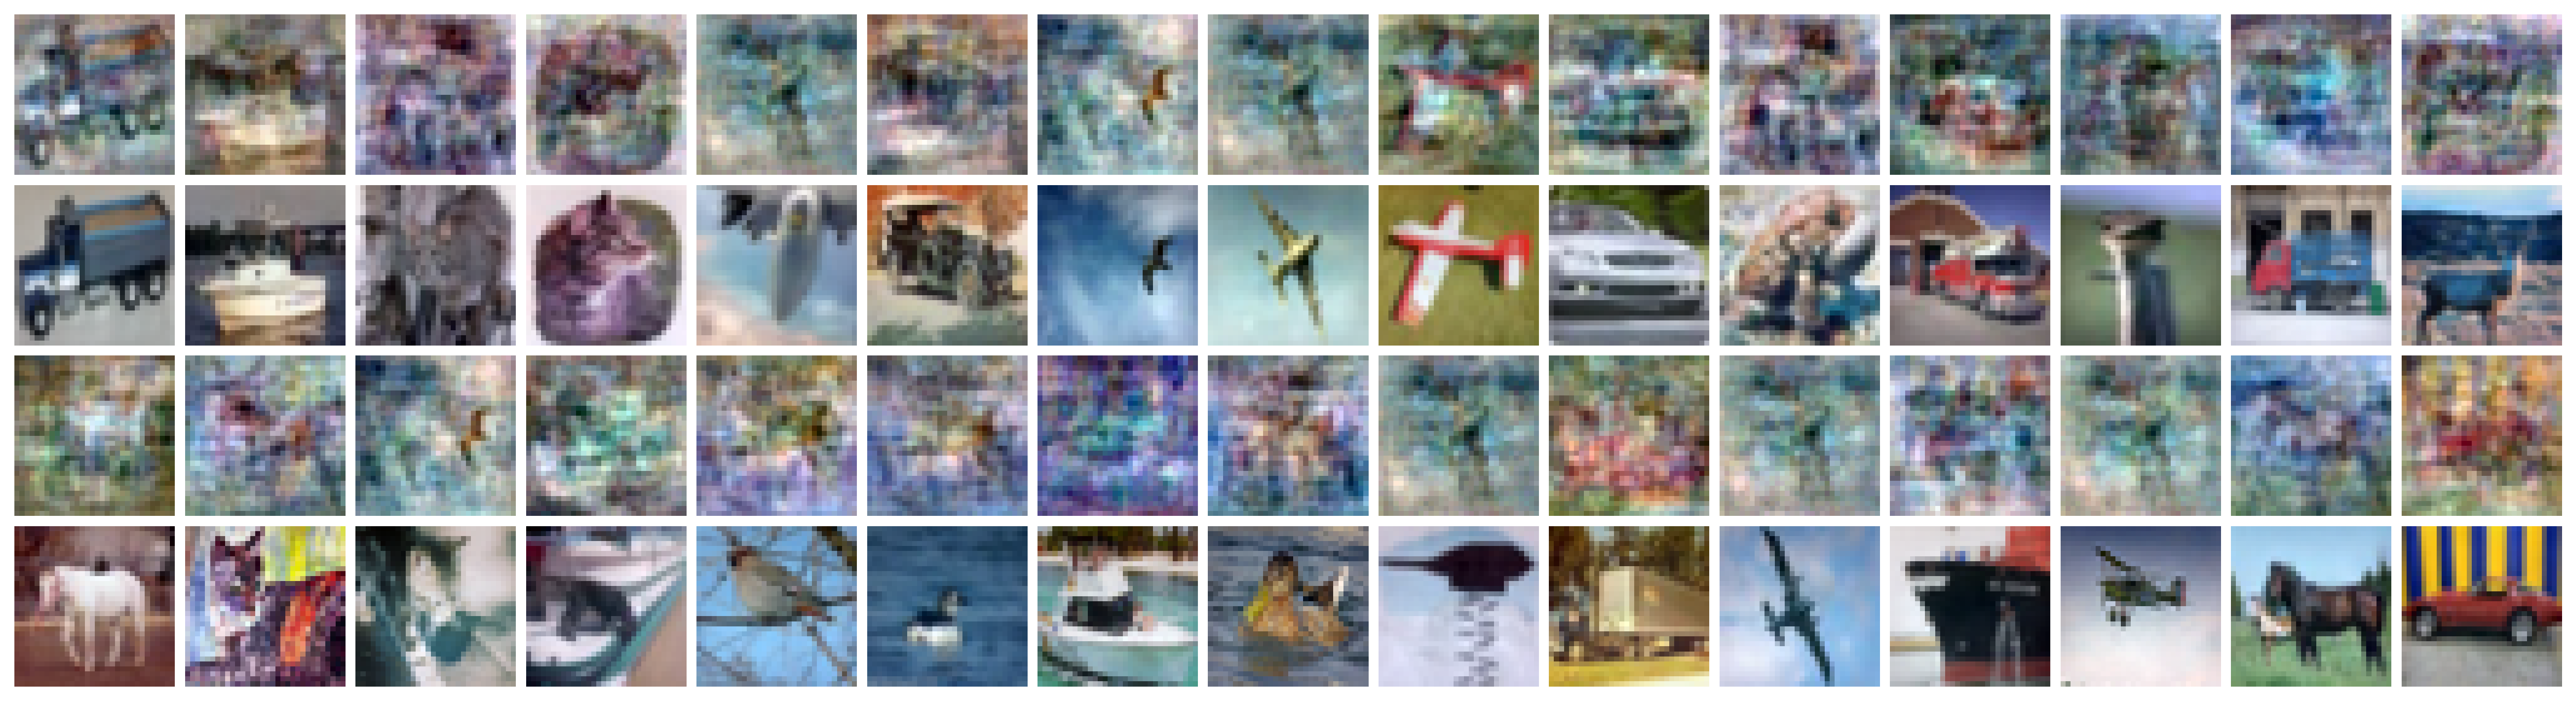

DONE!
Reconstruction visualization of model trained regularized loss
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60
Saved fig at: /content/drive/My Drive/ColabFiles/CifarReconstruct/results/08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot/figures/vis_best_reco_of_art_12500_run.png


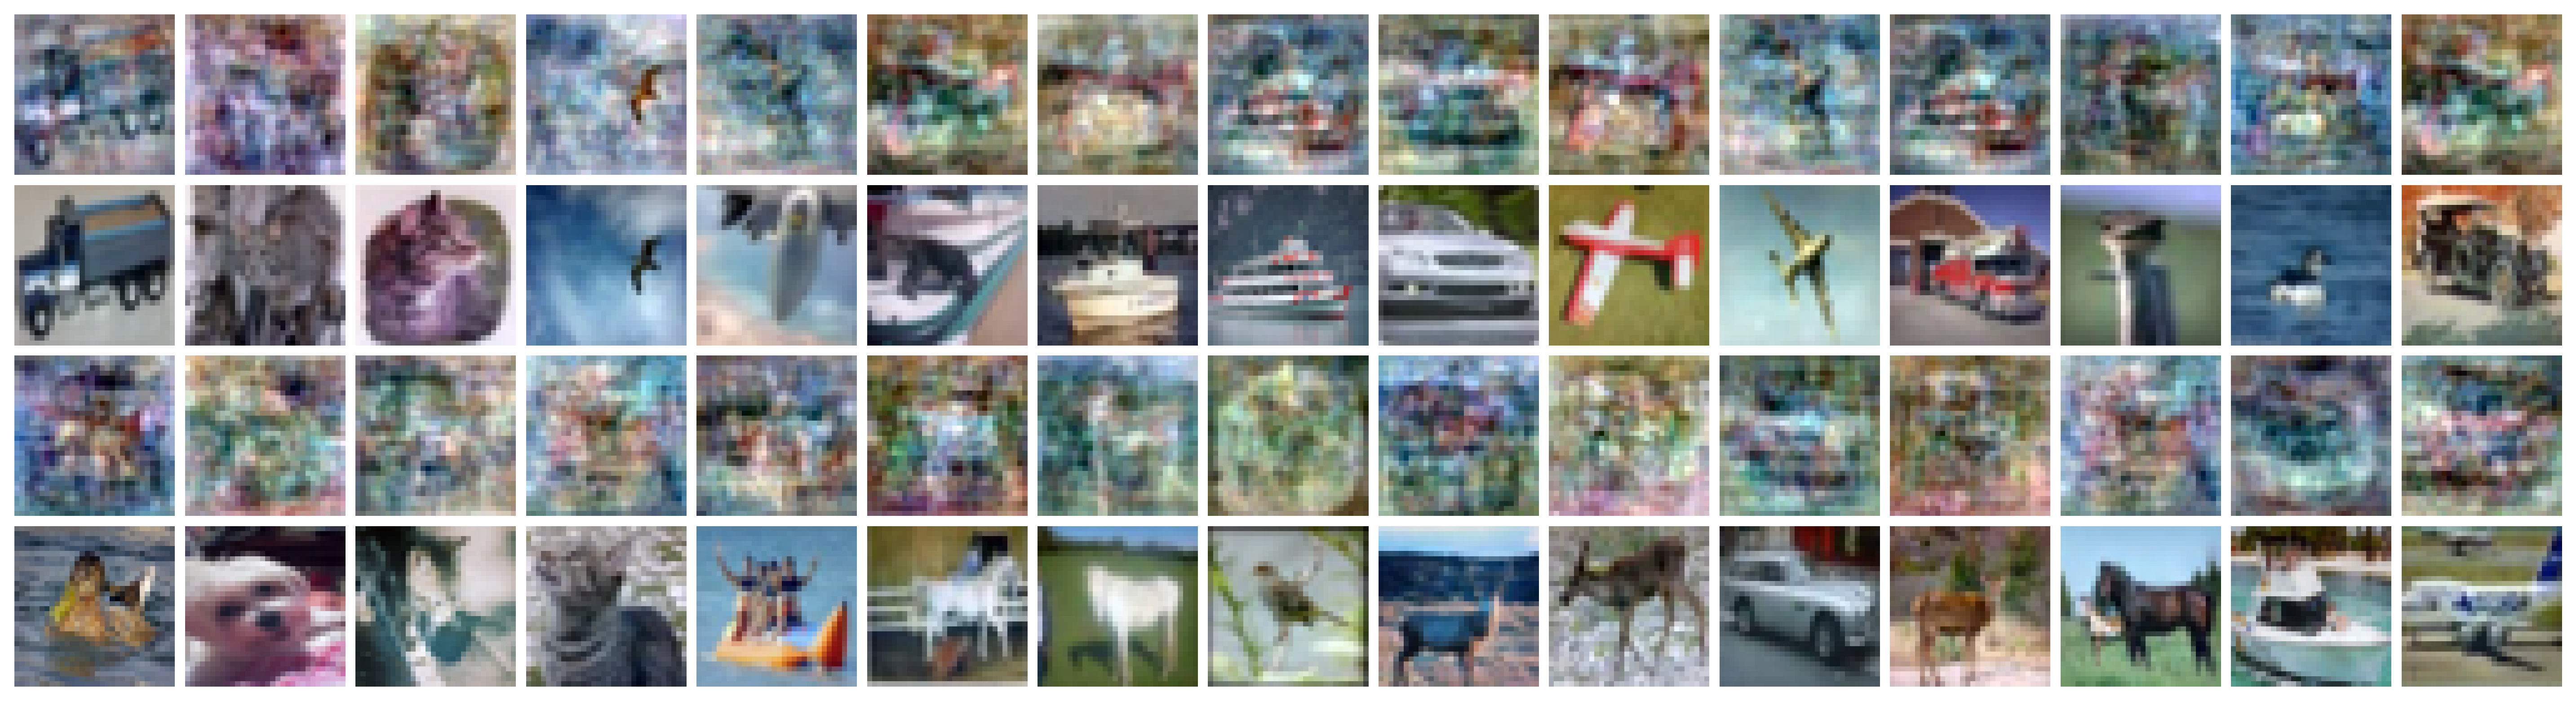

DONE!


NameError: name 'stop' is not defined

In [ ]:
# Visualizing reconstructions:
##############################
# The trained art runs folders:
# 08_07_19_32_22_934872_test_training_regularization_epoch_e_6_neg_kkt_loss
# 08_07_22_09_10_925510_test_training_regularization_epoch_e_6_inv_kkt_loss
# 08_13_02_26_45_647158_test_training_regularization


# checking reconstruction of trained model with regularization std_loss - alpha * kkt_loss
#loaded_test_folder    = '08_07_19_32_22_934872_test_training_regularization'
#plot_reco(loaded_test_folder)

# checking reconstruction of trained model with regularization std_loss + alpha * 1/kkt_loss
#loaded_test_folder    = '08_07_22_09_10_925510_test_training_regularization'
#plot_reco(loaded_test_folder)

# checking reconstruction of trained model with regularization std_loss + alpha * 1/kkt_loss
#loaded_test_folder    = '08_13_02_26_45_647158_test_training_regularization'
#plot_reco(loaded_test_folder)


loaded_test_folder    = '08_14_17_53_05_315381_test_training_regularization_reco_at_sweetspot'
plot_reco(loaded_test_folder, model_trn_leangth =  1250)
plot_reco(loaded_test_folder, model_trn_leangth =  2500)
plot_reco(loaded_test_folder, model_trn_leangth =  3750)
plot_reco(loaded_test_folder, model_trn_leangth =  5000)
plot_reco(loaded_test_folder, model_trn_leangth =  6250)
plot_reco(loaded_test_folder, model_trn_leangth =  7500)
plot_reco(loaded_test_folder, model_trn_leangth =  8750)
plot_reco(loaded_test_folder, model_trn_leangth = 10000)
plot_reco(loaded_test_folder, model_trn_leangth = 11250)
plot_reco(loaded_test_folder, model_trn_leangth = 12500)

stop

**Observation**:

When training 10 epochs and reconstructing 50 epochs, we get reconstructions that are very similar to the normalization, that is, to the mean of the features.

it also looks the same in 200,000 epochs of training.

# Saving and Loading model weights + data verification

Flow:


1.   Create new test instance with new dun dir; Save its weights in the run dir
2.   get rundir
3. create a new test without a new rundir, load the wights
4. compare the weight

In [ ]:
# 1
f_name = f'testing_save_model_std.pth'
test.save_weights(test.model_std, f_name)
f_name = f'testing_save_model_art.pth'
test.save_weights(test.model_art, f_name)

In [ ]:
# 2
# It is suficient to do the check on one of the models, checking only 'orig'
weights_path = test.args.output_model_dir
print(weights_path)

f_name = f'testing_save_model_std.pth'
loaded_dict = test.load_weights(f_name)
print(loaded_dict.keys())

In [ ]:
# 3
loaded_test_folder = '07_28_21_10_31_777286_test_data_norm'
loaded_test = TestRegularizationTermEffect(nof_epochs = 4, train_evaluate_all_thrs = 3500, new_test = False, run_name = loaded_test_folder, verbose = True, seed = 621)
loaded_test.model_std = loaded_test.model_std = create_model(loaded_test.args, extraction=False)
loaded_test.model_std.load_state_dict(loaded_dict['state_dict'])

In [ ]:
# 4
# loaded weights comparison
print(f'state dict keys of trained test: {list(test.model_std.state_dict())}')
print(f'state dict keys of loaded_test:  {list(loaded_test.model_std.state_dict())}')
for key1, key2 in zip(list(test.model_std.state_dict()), list(loaded_test.model_std.state_dict())):
  if key1 != key2:
    print(f'NOT OK; key1 = {key1}, key2 = {key2}')
    break
  trained_layer = test.model_std.state_dict()[key1]
  loaded_layer  = loaded_test.model_std.state_dict()[key2]
  if torch.equal(loaded_layer, trained_layer):
    print('OK')
  else:
    print(f'NOT OK, values mismatch in layer {key1}')

In [ ]:
# here: check also some values (say 20)
print(f'loaded tensor shape of layer {key1} is {test.model_std.state_dict()[key1].shape}')
val_snip_traned = test.model_std.state_dict()[key1][0][0:20]
val_snip_loaded = loaded_test.model_std.state_dict()[key1][0][0:20]
for val1, val2 in zip(val_snip_traned, val_snip_loaded):
  if val1 != val2:
    print(f'NOT OK; val1 = {val1} != val2 = {val2}')
    break
  print(val1, val2)

# Load weights from prior test to an un trained test.

In [ ]:
# Loading model and reconstructions from previous test
if test.new_test == False:
  loaded_test_folder = '07_28_21_10_31_777286_test_data_norm'
  loaded_test_path = os.path.join(test.args.results_dir, loaded_test_folder)
  print(f'Outputdir = "{test.args.output_dir}" of automatic path created at test instance')
  print(f'Outputdir = "{loaded_test_path}" of previous test with results')

In [ ]:
if test.new_test == False:
  test.args.output_dir = loaded_test_path
  print("Updatting args.output_dir")
  print(f'Outputdir = "{test.args.output_dir}" updated')

In [ ]:
# getting models and reconstructions (orig)
if test.new_test == False:
  f_name = f'testing_save_model_std.pth'
  test.model_std = create_model(test.args, extraction=False)
  print(test.model_std.eval())
  test.load_weights(f_name)
  print(f'state dict keys of loaded_test:  {list(test.model_std.state_dict())}')

# Misc

In [ ]:
import torch
list1 = torch.tensor([1, 2, 3])
list2 = [4, 5, 6]
list3 = [7, 8, 9]

zip_of_lists = list(zip((list1, list2)[0], (list1, list2)[1], list3))
print(zip_of_lists)

dataset = (list1, list2)
for i, (x, y) in enumerate([dataset]):
  print(f'i = {i}; x = {x}; y = {y}')